In [1]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [2]:
# set directory to the src folder for importing modules
import sys
sys.path.append(os.path.abspath("../src"))


---
---

# DATASET AND CHECKS

---
---


In [3]:
import keras
from keras import ops

# load data and tensors 
from data.loader import load_and_clean_raw_dataset
from data.dataset_builder import build_full_surface_feature_df
from data.tensor_builder import prepare_surface_and_feature_tensors

df_raw = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")
df_all = df_all.dropna()

iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]

tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df_raw,
    feat_cols=feat_cols,
    monthly_interpolation=False
)


In [5]:
# config pipeline constants 
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = len(feat_cols)
LOOKBACK = 20
M, K = SURFACE_SHAPE
BATCH_SIZE = 32
TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0
print(f"Feature Dimension: {FEATURE_DIM}")

Feature Dimension: 26



Feature tensor: (1258, 136)
Feature DataFrame: (1258, 26)
Final DataFrame shape: (1265, 136)
Surface columns: 110 | Feature columns: 26


C:\Users\alessandro.esposito\AppData\Local\Temp\ipykernel_8836\864578001.py:76: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


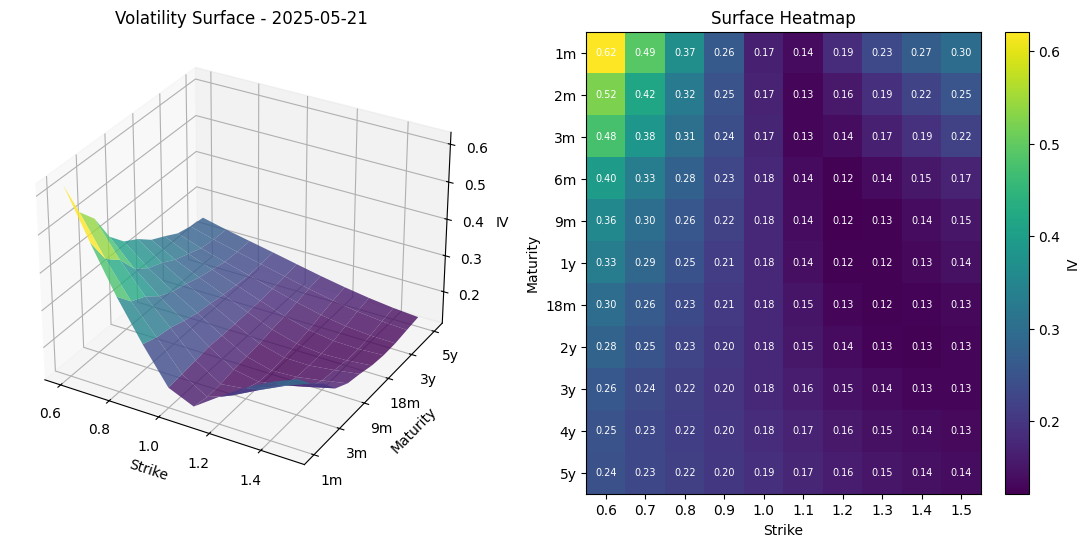

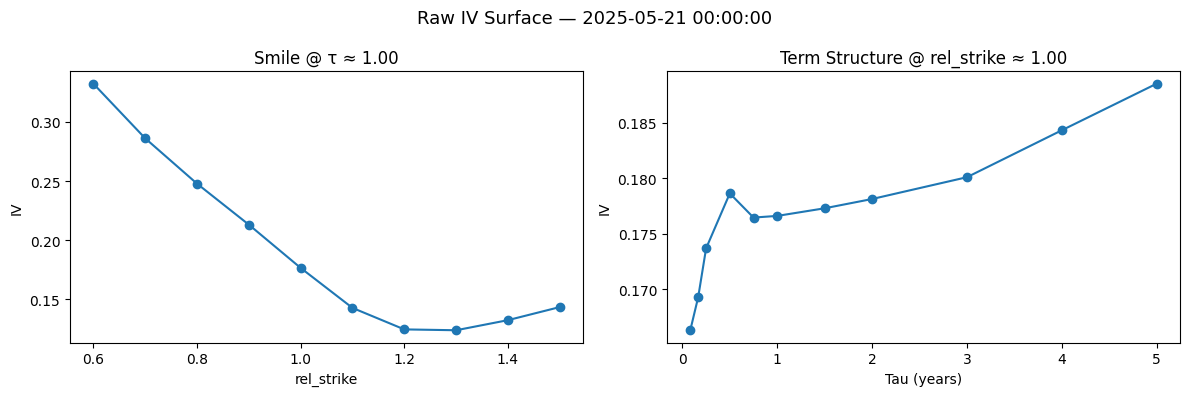

In [6]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils.plotting import plot_raw_iv_slice

# check dimensions
print("\nFeature tensor:", ops.convert_to_numpy(X_feat_tensor).shape)
print("Feature DataFrame:", df_feat.shape)

# identify columns
iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print("Final DataFrame shape:", df_all.shape)
print("Surface columns:", len(iv_cols), "| Feature columns:", len(feat_cols))

# extract surface
ix = -1
date = df_all.index[ix]

# maturity ordering
maturity_to_tau = {
   '1m': 1/12, '2m': 2/12, '3m': 3/12, '6m': 0.5, '9m': 0.75,
   '1y': 1.0, '18m': 1.5, '2y': 2.0, '3y': 3.0, '4y': 4.0, '5y': 5.0
}

# parse and sort dimensions
all_maturities = list(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
maturities = sorted(all_maturities, key=lambda x: maturity_to_tau[x])
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# reshape surface with correct ordering
surface_values = np.zeros((len(maturities), len(strikes)))
for i, mat in enumerate(maturities):
   for j, strike in enumerate(strikes):
       col_name = f"IV_{mat}_{strike:.2f}"
       surface_values[i, j] = df_all.iloc[ix][col_name]

# create combined visualization
fig = plt.figure(figsize=(14, 6))

# 3d surface
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(range(len(strikes)), range(len(maturities)))
ax1.plot_surface(X, Y, surface_values, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('IV')
ax1.set_title(f'Volatility Surface - {date.strftime("%Y-%m-%d")}')
ax1.set_xticks(range(0, len(strikes), 2))
ax1.set_xticklabels([strikes[i] for i in range(0, len(strikes), 2)])
ax1.set_yticks(range(0, len(maturities), 2))
ax1.set_yticklabels([maturities[i] for i in range(0, len(maturities), 2)])

# heatmap with values
ax2 = fig.add_subplot(122)
im = ax2.imshow(surface_values, cmap='viridis', aspect='auto')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_title('Surface Heatmap')
ax2.set_xticks(range(len(strikes)))
ax2.set_xticklabels([f'{s:.1f}' for s in strikes])
ax2.set_yticks(range(len(maturities)))
ax2.set_yticklabels(maturities)

# add text annotations
for i in range(len(maturities)):
   for j in range(len(strikes)):
       text = ax2.text(j, i, f'{surface_values[i, j]:.2f}',
                      ha="center", va="center", color="white", fontsize=7)

plt.colorbar(im, ax=ax2, label='IV')
plt.tight_layout()
plt.show()

# raw data visualization
plot_raw_iv_slice(df_raw, target_date=date, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU)

---
---

# PCA - VAR PIPELINE

---
---

PCA-VAR RMSE: 0.0166
df_all length: 1265
Y_true_pca length: 378
Y_hat_pca length: 378
Dates passed to function: 1265
2021-10-19 is at index 1264 in df_all
Evaluation dimensions: N=378, M=11, K=10
PCA-VAR Baseline RMSE_σ: 0.0166
RMSE by maturity (mean ± std): 0.0171 ± 0.0099
RMSE by strike    (mean ± std): 0.0191 ± 0.0051
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


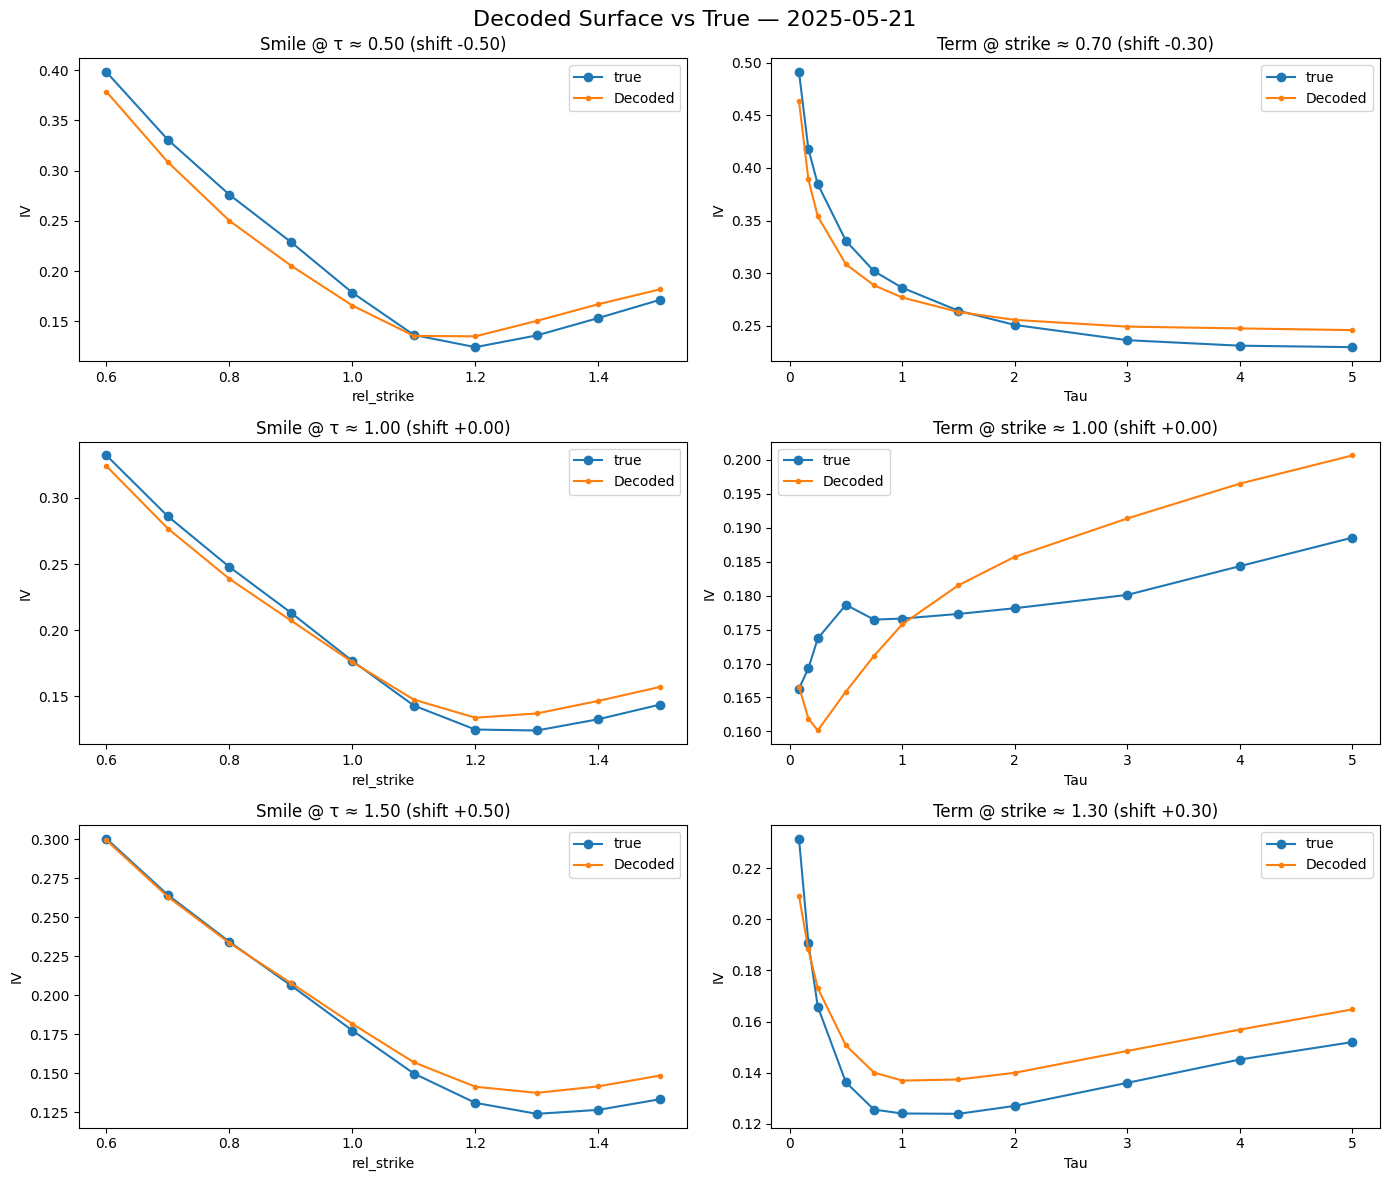

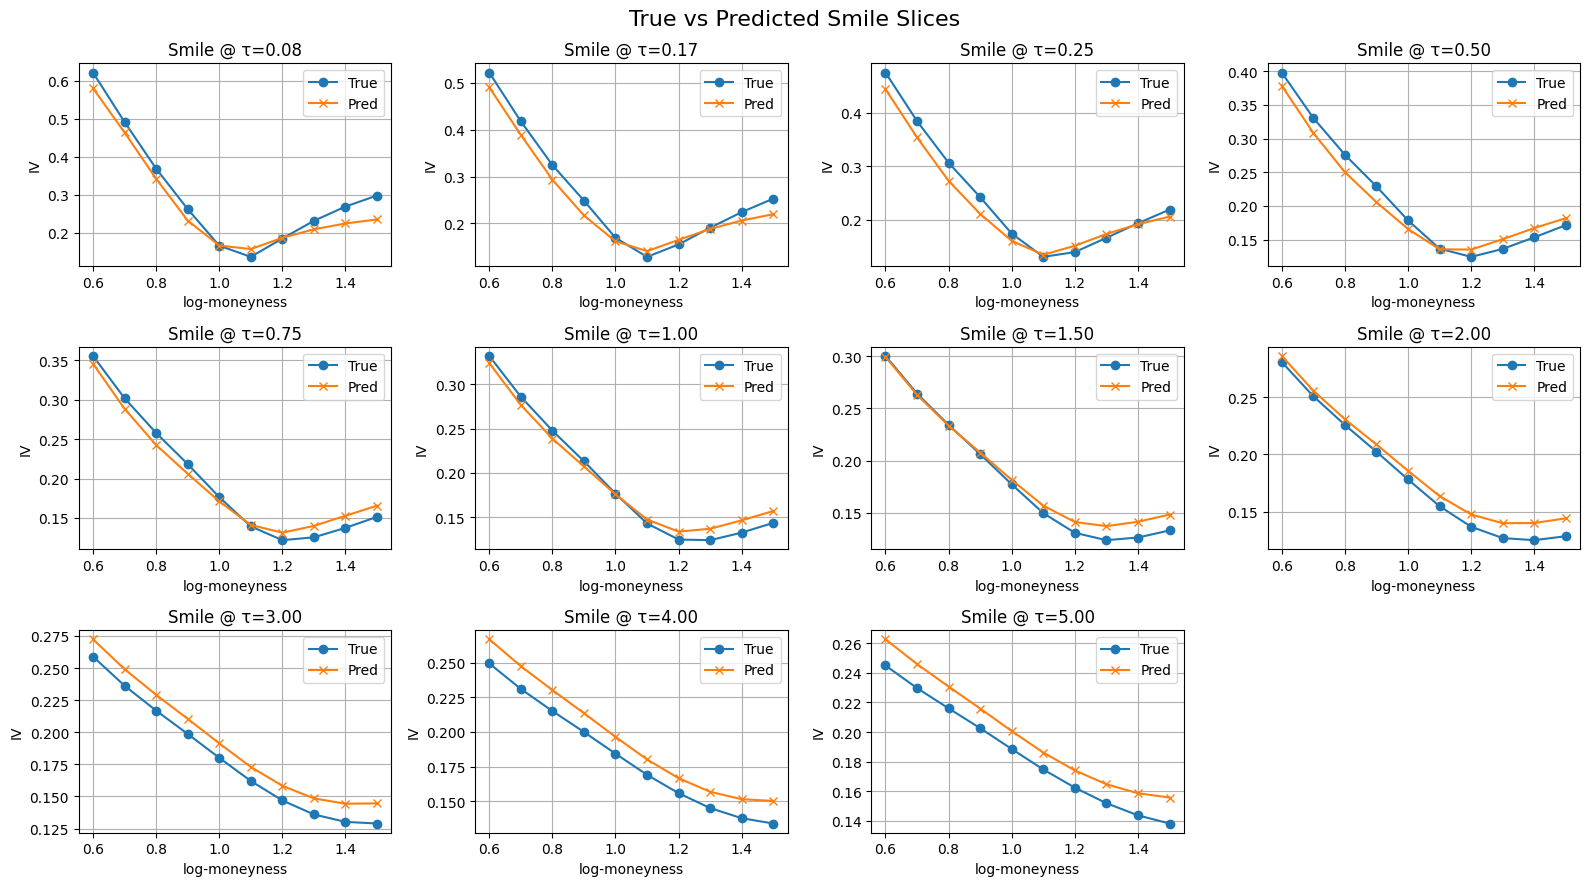

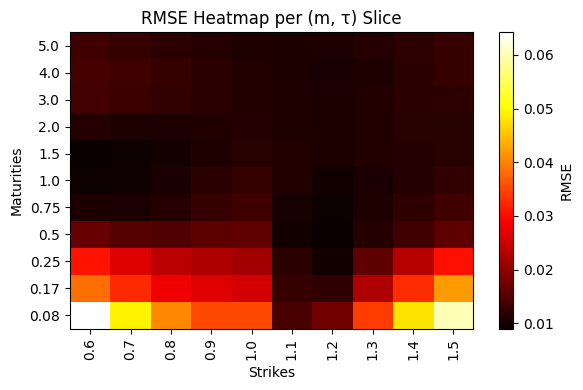

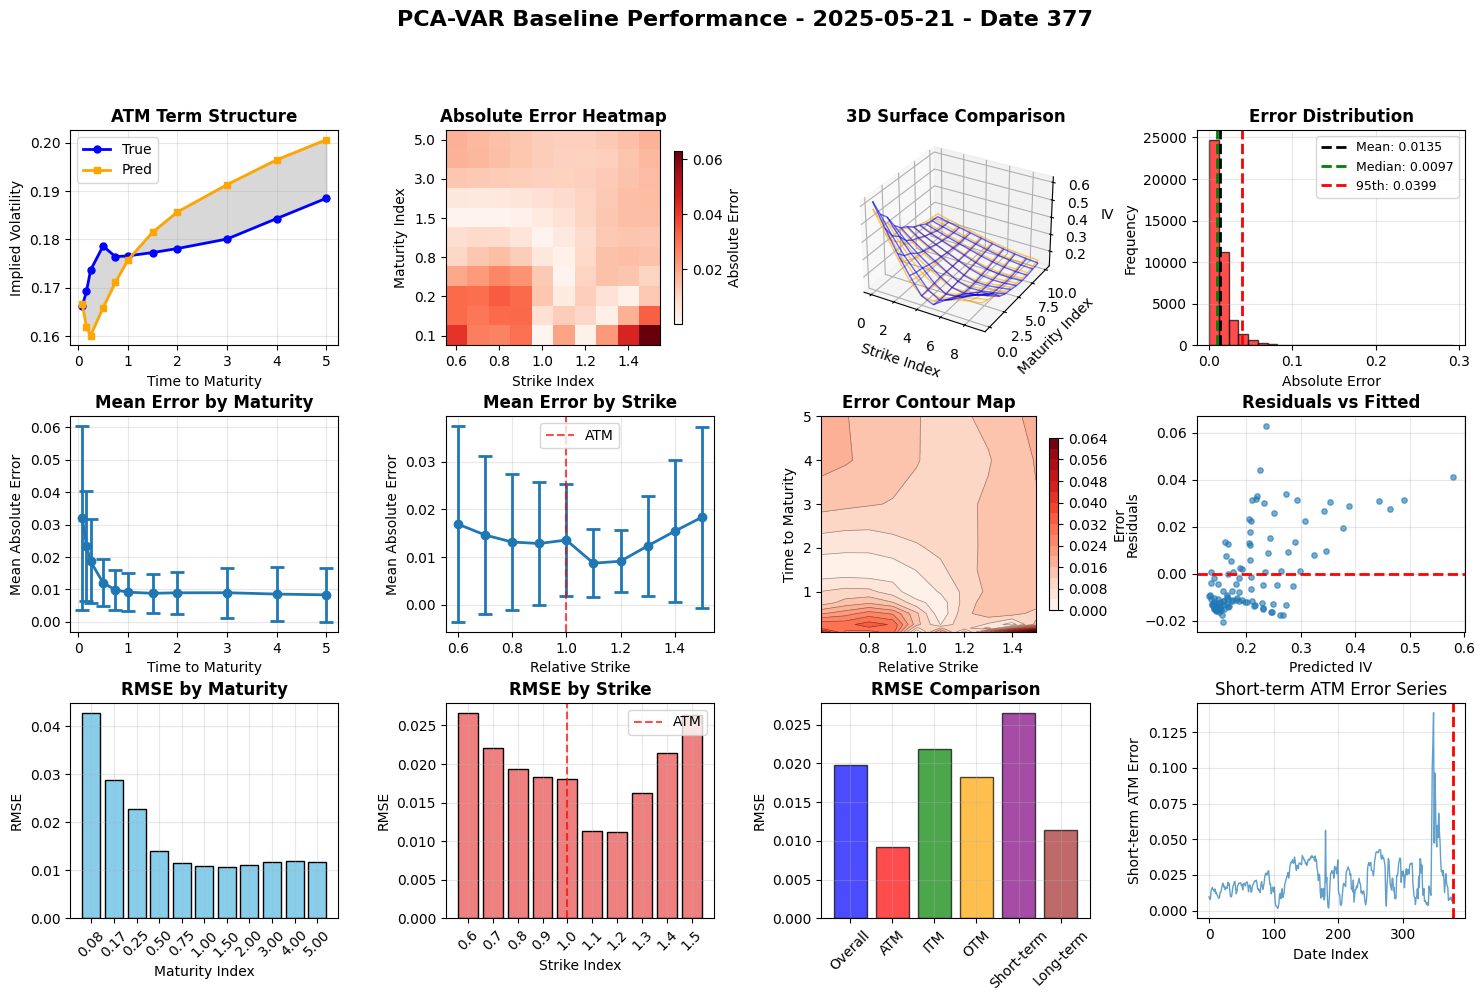

Overall Performance Category Performance  \
RMSE                           0.019744                  NaN   
MAE                            0.013521                  NaN   
Max Error                      0.292387                  NaN   
Mean Error                     0.013521                  NaN   
Median Error                   0.009724                  NaN   
95th Percentile                0.039889                  NaN   
ATM RMSE                            NaN             0.009175   
ITM RMSE                            NaN             0.021806   
OTM RMSE                            NaN             0.018286   
Short-term RMSE                     NaN             0.026501   
Long-term RMSE                      NaN             0.011377   
Short/Long Ratio                    NaN                2.329   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.50 (RMSE: 0.010647)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.042762)                       NaN  
Best Strike           K=1.2 (RMSE: 0.011200)                       NaN  
Worst Strike          K=0.6 (RMSE: 0.026603)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.018015)                       NaN  
Overall Rank              ATM ranks #4 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.329)  
ATM Issues                               NaN   NO (ATM/Overall: 0.46x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.003520)  
High Error Variance                      NaN       YES (std: 0.014388)  
Model Quality                            NaN                      GOOD  
Recommendation                           NaN         Needs Improvement

In [7]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error

# Extract Y (true surfaces) and X (market variables)
Y = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]  # (T, M, K)
T, M, K = Y.shape
Y_flat = Y.reshape(T, M * K).astype(np.float64)

# Align and extract F (engineered features)
feature_index = df_feat.index.intersection(df_all.index)
X = df_all.loc[feature_index, iv_cols].values.astype(np.float64)  # Market variables
F = df_feat.loc[feature_index].values.astype(np.float64)         # f(X) features

# PCA encoding: Y + F -> ZF
Y_mean = X.mean(axis=1, keepdims=True)
Y_demeaned = X - Y_mean
pca_encoder = PCA(n_components=LATENT_DIM)
Z_pca = pca_encoder.fit_transform(Y_demeaned)
ZF_pca = np.concatenate([Z_pca, F], axis=1)  # ZF(t) = Enc(Y+F)

# Train/test split
T_train = int(0.7 * T)
ZF_train = ZF_pca[:T_train]
ZF_test = ZF_pca[T_train:]

# Temporal model: ZF(t) -> ZF(t+1)
var_model = VAR(ZF_train)
var_result = var_model.fit(maxlags=5)
ZF_pred = var_result.forecast(ZF_train[-var_result.k_ar:], steps=len(ZF_test))
Z_pred = ZF_pred[:, :LATENT_DIM]  # Extract latent component

# Decoder: ZF(t+1) -> Y'(t+1)
Y_recon_demeaned = pca_encoder.inverse_transform(Z_pred)
Y_mean_pred = Y_mean[T_train:T_train + len(Y_recon_demeaned)]
Y_hat_flat = Y_recon_demeaned + Y_mean_pred  # Y^(t+1)

# Ground truth
Y_true_flat = X[T_train:T_train + len(Y_hat_flat)]

# Metrics
rmse_pca = root_mean_squared_error(Y_true_flat, Y_hat_flat)
print(f"PCA-VAR RMSE: {rmse_pca:.4f}")

# Reshape for evaluation
Y_true_pca = Y_true_flat.reshape(-1, M, K)
Y_hat_pca = Y_hat_flat.reshape(-1, M, K)

# check the length of your PCA predictions
print(f"df_all length: {len(df_all)}")
print(f"Y_true_pca length: {len(Y_true_pca)}")
print(f"Y_hat_pca length: {len(Y_hat_pca)}")

# check what date index -1 corresponds to in your PCA data
# the PCA data might be a subset (like test set only)
print(f"Dates passed to function: {len(df_all.index)}")

# if Y_true_pca is shorter, it might be test data only
# find where 2021-10-19 is in your data
target_date = pd.Timestamp(TARGET_DATE)
idx = df_all.index.get_loc(target_date)
print(f"2021-10-19 is at index {idx} in df_all")



# Evaluation
from utils.eval import evaluate_decoder_output_v2
evaluate_decoder_output_v2(
    Y_pred=Y_hat_pca,
    Y_true=Y_true_pca,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=None,
    title="PCA-VAR Baseline"
)
from utils.plot_error import analyze_decoder_comprehensive

pca_dates = df_all.index[T_train:T_train + len(Y_true_pca)]

metrics_pca = analyze_decoder_comprehensive(
    Y_true=Y_true_pca,
    Y_pred=Y_hat_pca,
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    date_idx=-1,
    dates=None,  # Pass only the dates for PCA test set
    title=f"PCA-VAR Baseline Performance - {TARGET_DATE}" 
)

In [8]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# Summarize PCA-VAR results
summary_pca = summarize_decoder_errors(
   Y_true=Y_true_pca, 
   Y_pred=Y_hat_pca,
   taus=ops.convert_to_numpy(tensors["taus"]), 
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   name="PCA-VAR Baseline",
   model=None
)

# Initialize comparison collection
summary_all_models = collect_decoder_summaries(
   summary_pca,  # PCA-VAR baseline
   # VAE-GRU-VAE-MoE pipeline results will be added here...
)

display(summary_all_models)

Name  Rank Overall_RMSE Overall_MAE  ATM_RMSE   ATM_MAE  \
0  PCA-VAR Baseline     1     0.019744    0.013521  0.018015  0.013584   

   ITM_RMSE  OTM_RMSE Short_Long_Ratio Max_Error  Short_Term_Bias  ATM_Issues  \
0  0.021806  0.018286         2.329421  0.292387             True       False   

  Model_Quality  Production_Ready  
0          GOOD             False

---
---

# DATASET CREATION

---
---

In [9]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices, slice_tensors
from data.dataset import FeatureToSurfaceDataset
from keras import ops
import pandas as pd
import numpy as np



# Time-series split (respecting temporal order)
T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

train_tensors = slice_tensors(tensors, train_idx)
val_tensors = slice_tensors(tensors, val_idx)
test_tensors = slice_tensors(tensors, test_idx)

# Create VAE datasets: Input = YF_combined (surfaces + features), Target = Y (surfaces only)
train_dataset_vae = FeatureToSurfaceDataset(
    surface_tensor=train_tensors["surface_tensor"],  # Y targets
    feature_tensor=X_feat_tensor[train_idx],         # F features
    date_tensor=train_tensors["date_tensor"],
    batch_size=BATCH_SIZE,
    global_indices=train_idx
)

val_dataset_vae = FeatureToSurfaceDataset(
    surface_tensor=val_tensors["surface_tensor"],
    feature_tensor=X_feat_tensor[val_idx],
    date_tensor=val_tensors["date_tensor"],
    batch_size=BATCH_SIZE,
    global_indices=val_idx
)

test_dataset_vae = FeatureToSurfaceDataset(
    surface_tensor=test_tensors["surface_tensor"],
    feature_tensor=X_feat_tensor[test_idx],
    date_tensor=test_tensors["date_tensor"],
    batch_size=BATCH_SIZE,
    global_indices=test_idx
)

# Extract data dimensions
M, K = tensors["surface_tensor"].shape[1:3]
SURFACE_DIM = M * K  # 110 (Y dimensions)
FEATURE_DIM = X_feat_tensor.shape[1] - SURFACE_DIM  # 26 (F dimensions) 
COMBINED_DIM = X_feat_tensor.shape[1]  # 136 (YF_combined dimensions)

print(f"\n[VAE Dataset Configuration]")
print(f"  - Train samples: {len(train_dataset_vae)} batches ({len(train_idx)} samples)")
print(f"  - Val samples:   {len(val_dataset_vae)} batches ({len(val_idx)} samples)")
print(f"  - Test samples:  {len(test_dataset_vae)} batches ({len(test_idx)} samples)")
print(f"  - Input dim (YF): {COMBINED_DIM} = {SURFACE_DIM}(Y) + {FEATURE_DIM}(F)")
print(f"  - Latent dim (Z): {LATENT_DIM}")
print(f"  - Surface shape:  ({M}, {K})")

# Verify data flow
sample_input, sample_target = train_dataset_vae[0]
print(f"\n[Data Flow Verification]")
print(f"  - Batch input shape:  {sample_input.shape} (YF_combined)")
print(f"  - Batch target shape: {sample_target.shape} (Y targets)")
print(f"  - Input = surfaces + features concatenated")
print(f"  - Target = surfaces only (for reconstruction loss)")

# Check target date alignment
target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]
print(f"\n[Target Date Check]")
print(f"  - Target date {target_date} at global index: {idx}")
print(f"  - In test set: {idx in test_dataset_vae.global_indices}")
print(f"  - Train range: [{train_idx[0]}, {train_idx[-1]}]")
print(f"  - Val range:   [{val_idx[0]}, {val_idx[-1]}]") 
print(f"  - Test range:  [{test_idx[0]}, {test_idx[-1]}]")


[VAE Dataset Configuration]
  - Train samples: 28 batches (880 samples)
  - Val samples:   6 batches (189 samples)
  - Test samples:  6 batches (189 samples)
  - Input dim (YF): 136 = 110(Y) + 26(F)
  - Latent dim (Z): 12
  - Surface shape:  (11, 10)

[Data Flow Verification]
  - Batch input shape:  torch.Size([32, 246]) (YF_combined)
  - Batch target shape: torch.Size([32, 246]) (Y targets)
  - Input = surfaces + features concatenated
  - Target = surfaces only (for reconstruction loss)

[Target Date Check]
  - Target date 2025-05-21 00:00:00 at global index: 1257
  - In test set: True
  - Train range: [0, 879]
  - Val range:   [880, 1068]
  - Test range:  [1069, 1257]


In [10]:
import importlib
import models.vae_mle
importlib.reload(models.vae_mle)

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.vae_mle import VAE, build_encoder, build_decoder, VAETrainingDebugCallback, KLEpochTracker
import os

# vae setup
os.makedirs("saved_models/vae_gru_moe", exist_ok=True)

vae_beta = 0.2
optimizer_vae = Adam(1e-5)

YF_train = train_dataset_vae.to_tensor()
YF_val = val_dataset_vae.to_tensor()

print(f"VAE Training Data:")
print(f"  YF_train shape: {YF_train.shape}")
print(f"  YF_val shape: {YF_val.shape}")
print(f"  Input dim: {YF_train.shape[1]} to latent: {LATENT_DIM}")

# build vae
encoder_vae = build_encoder(input_dim=YF_train.shape[1], latent_dim=LATENT_DIM)
decoder_vae = build_decoder(output_dim=YF_train.shape[1], latent_dim=LATENT_DIM)
vae_model = VAE(encoder=encoder_vae, decoder=decoder_vae, beta=vae_beta, kl_warmup=True)
vae_model.compile(optimizer=optimizer_vae)

debug_callback_vae = VAETrainingDebugCallback(vae_model=vae_model, X_val=YF_val)
callbacks_vae = [
   KLEpochTracker(vae_model),
   debug_callback_vae,
   ModelCheckpoint("saved_models/vae_gru_moe/encoder_vae.weights.h5", 
                  monitor="val_loss", save_best_only=True, save_weights_only=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5),
   EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=False)
]

print("\nTraining VAE")
history_vae = vae_model.fit(
   YF_train, YF_train,
   validation_data=(YF_val, YF_val),
   epochs=300,
   batch_size=BATCH_SIZE,
   callbacks=callbacks_vae,
   verbose=1
)

vae_model.save("saved_models/vae_gru_moe/vae_full_model.keras")
vae_model.encoder.save("saved_models/vae_gru_moe/encoder_vae.keras")
vae_model.decoder.save("saved_models/vae_gru_moe/decoder_vae.keras")

print(f"\nVAE training done")
print(f"Saved to saved_models/vae_gru_moe/")

VAE Training Data:
  YF_train shape: torch.Size([880, 246])
  YF_val shape: torch.Size([189, 246])
  Input dim: 246 to latent: 12

Training VAE
Epoch 1/300
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0410 - loss: -0.2389 - reconstruction_loss: -0.2389 - z_logvar_mean: 0.0313 - z_std: 0.1839[vae_mle_debug | Epoch 001] Recon mle: 0.202203 | z_std: 0.1497 | z_mean_abs: 0.1262 | z_logvar_mean: -0.0417
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - kl_loss: 0.0404 - loss: -0.2396 - reconstruction_loss: -0.2396 - z_logvar_mean: 0.0281 - z_std: 0.1824 - val_kl_loss: 0.0247 - val_loss: -0.2721 - val_reconstruction_loss: -0.2721 - val_val_z_logvar_mean: -0.0414 - val_val_z_std: 0.1483 - val_z_logvar_mean: -0.0414 - val_z_std: 0.1483 - learning_rate: 1.0000e-05
Epoch 2/300
24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 0.0274 - loss: -0.2629 - reconstruction_loss: -0.2629 - z_logvar_mean: -0.0827 - z_std: 0.1504[vae_mle_debug | Epoch 002] Recon mle: 0.187351 | z_std: 0.1634 | z_mean_abs

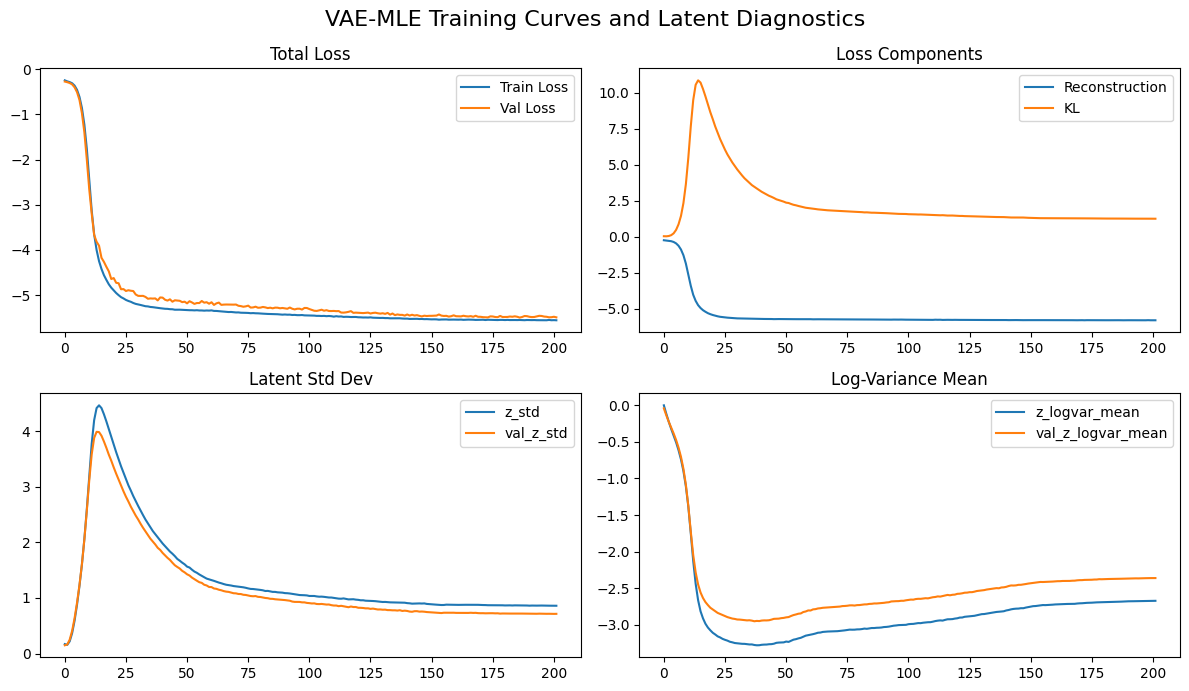

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
plt.suptitle("VAE-MLE Training Curves and Latent Diagnostics", fontsize=16)

# --- Top row: loss curves
axs[0, 0].plot(history_vae.history["loss"], label="Train Loss")
axs[0, 0].plot(history_vae.history.get("val_loss", []), label="Val Loss")
axs[0, 0].set_title("Total Loss")
axs[0, 0].legend()

axs[0, 1].plot(history_vae.history.get("reconstruction_loss", []), label="Reconstruction")
axs[0, 1].plot(history_vae.history.get("kl_loss", []), label="KL")
axs[0, 1].set_title("Loss Components")
axs[0, 1].legend()

# --- Bottom row: latent diagnostics
axs[1, 0].plot(history_vae.history.get("z_std", []), label="z_std")
axs[1, 0].plot(history_vae.history.get("val_z_std", []), label="val_z_std")

axs[1, 0].set_title("Latent Std Dev")
axs[1, 0].legend()

axs[1, 1].plot(history_vae.history.get("z_logvar_mean", []), label="z_logvar_mean")
axs[1, 1].plot(history_vae.history.get("val_z_logvar_mean", []), label="val_z_logvar_mean")
axs[1, 1].set_title("Log-Variance Mean")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


VAE Evaluation Dataset: torch.Size([1258, 246])

VAE Test Metrics:
Reconstruction: -5.474164 | KL: -5.692083 | Z_std: 1.089592

VAE Encoding Results:
Z_vae shape: (1258, 12)
Z_vae mean: -0.0596 ± 0.8276
VAE Surface RMSE: 0.024391
Evaluation dimensions: N=1258, M=11, K=10
VAE Encoder Reconstruction RMSE_σ: 0.0234
RMSE by maturity (mean ± std): 0.0238 ± 0.0053
RMSE by strike    (mean ± std): 0.0241 ± 0.0035
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


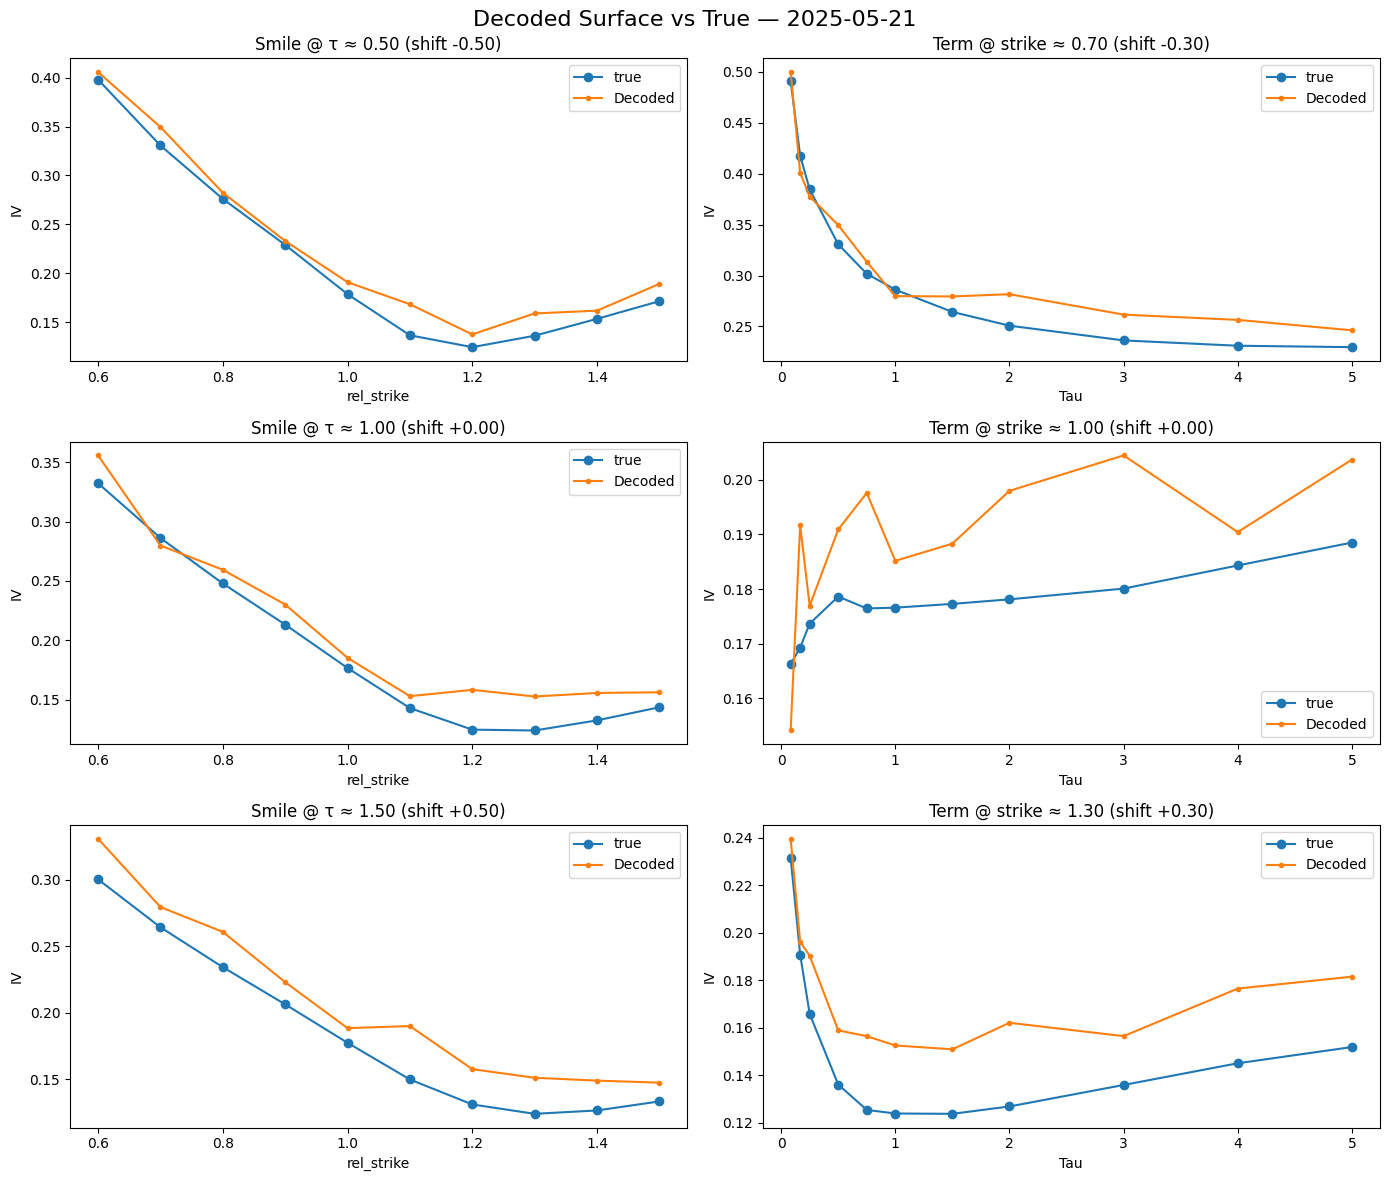

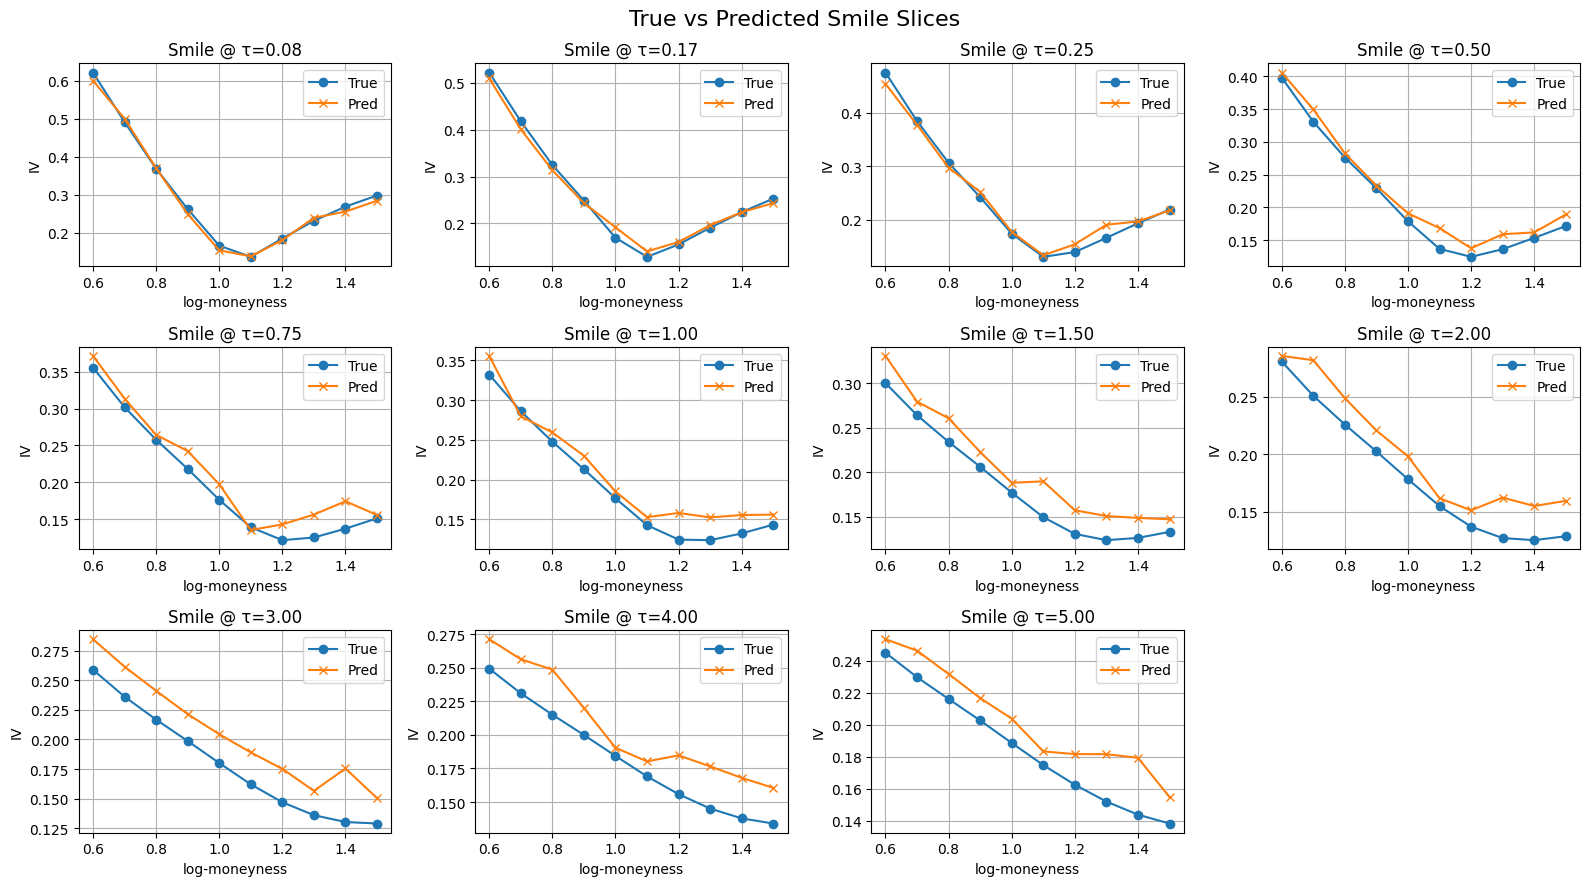

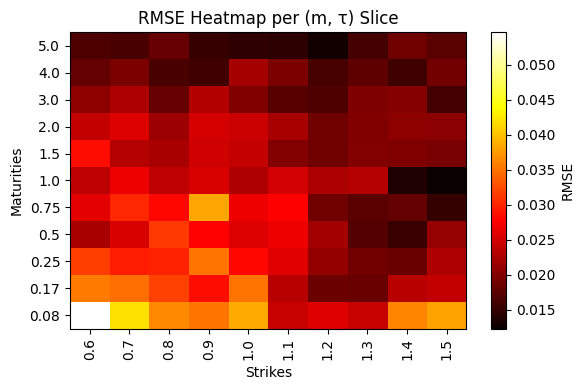

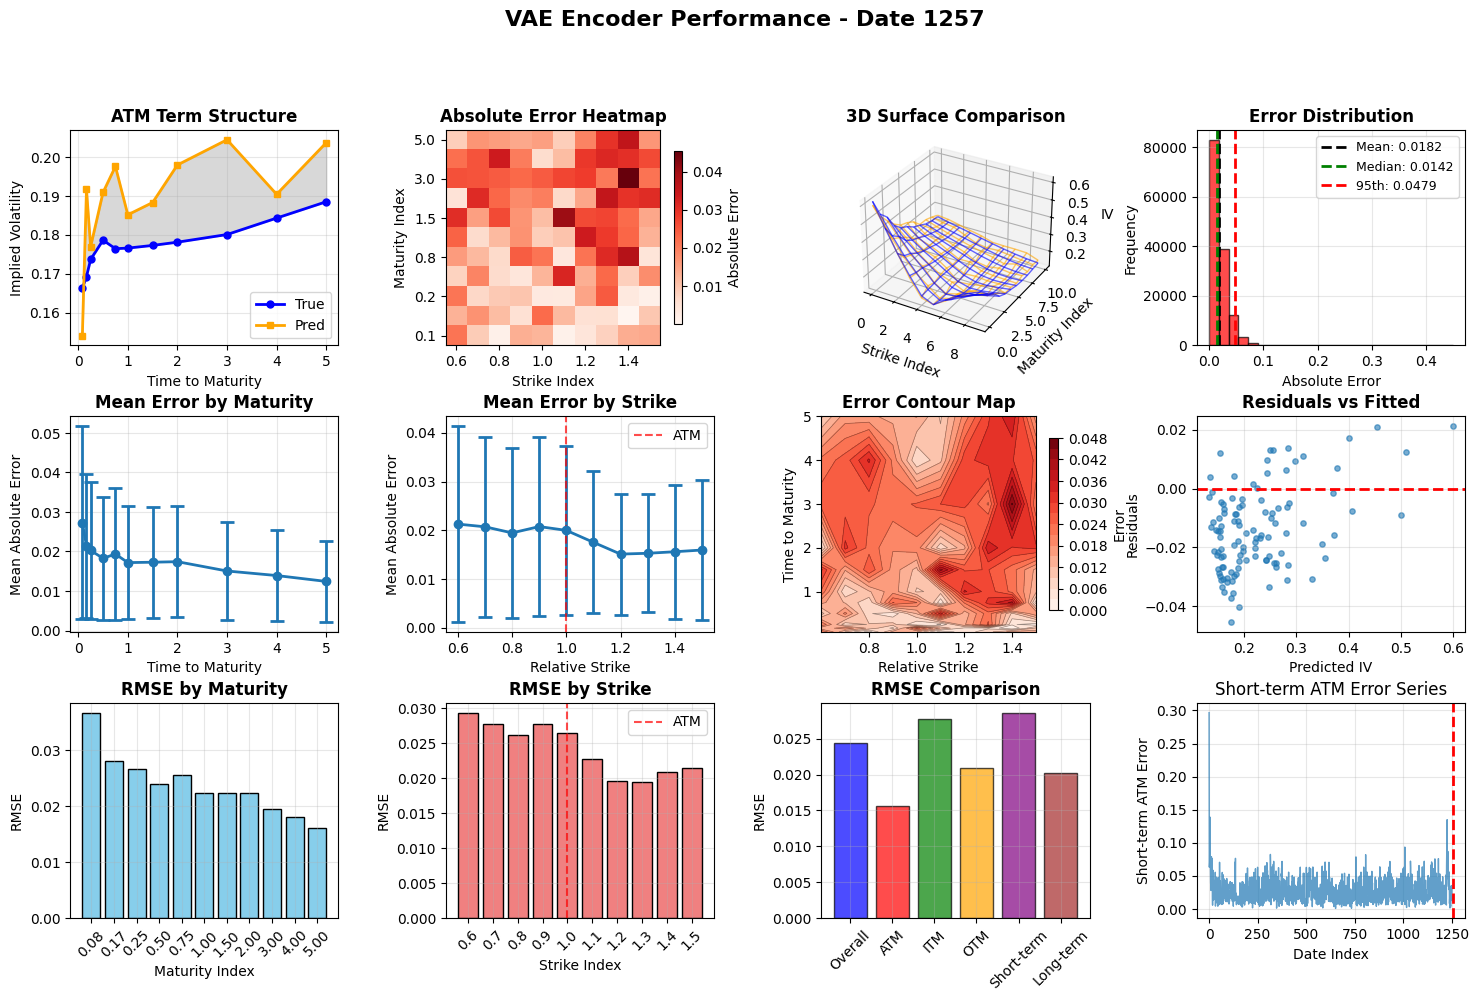

Overall Performance Category Performance  \
RMSE                           0.024391                  NaN   
MAE                            0.018172                  NaN   
Max Error                      0.448871                  NaN   
Mean Error                     0.018172                  NaN   
Median Error                   0.014199                  NaN   
95th Percentile                0.047900                  NaN   
ATM RMSE                            NaN             0.015692   
ITM RMSE                            NaN             0.027722   
OTM RMSE                            NaN             0.020862   
Short-term RMSE                     NaN             0.028549   
Long-term RMSE                      NaN             0.020285   
Short/Long Ratio                    NaN                1.407   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.016121)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.036623)                       NaN  
Best Strike           K=1.3 (RMSE: 0.019489)                       NaN  
Worst Strike          K=0.6 (RMSE: 0.029264)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.026441)                       NaN  
Overall Rank              ATM ranks #6 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.407)  
ATM Issues                               NaN   NO (ATM/Overall: 0.64x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.006860)  
High Error Variance                      NaN       YES (std: 0.016270)  
Model Quality                            NaN                      FAIR  
Recommendation                           NaN         Needs Improvement


VAE vs PCA:
PCA RMSE: 0.016563
VAE RMSE: 0.024391
Improvement: -47.27%


In [12]:
from utils.eval import evaluate_forecast, print_evaluation, evaluate_encoder, evaluate_decoder_output_v2
from utils.plot_error import analyze_decoder_comprehensive
from keras import ops
import pandas as pd
import numpy as np

# vae evaluation

# load full dataset
YF_full_vae = FeatureToSurfaceDataset(
  surface_tensor=tensors["surface_tensor"],
  feature_tensor=X_feat_tensor,
  date_tensor=tensors["date_tensor"],
  batch_size=None
).to_tensor()

print(f"VAE Evaluation Dataset: {YF_full_vae.shape}")

# test metrics
YF_test_vae = test_dataset_vae.to_tensor()
test_metrics_vae = vae_model.evaluate(YF_test_vae, YF_test_vae, verbose=0)
recon_loss_vae, kl_div_vae, z_std_vae = [float(x) for x in test_metrics_vae[:3]]

print(f"\nVAE Test Metrics:")
print(f"Reconstruction: {recon_loss_vae:.6f} | KL: {kl_div_vae:.6f} | Z_std: {z_std_vae:.6f}")

# extract latents and reconstruct
_, Z_mean_vae, _ = vae_model.encoder(YF_full_vae)
Z_vae = ops.convert_to_numpy(Z_mean_vae)
YF_recon_vae = vae_model.predict(YF_full_vae, verbose=0)

# extract surface components
Y_true_flat_vae = ops.convert_to_numpy(YF_full_vae[:, :SURFACE_DIM])
Y_recon_flat_vae = YF_recon_vae[:, :SURFACE_DIM]

print(f"\nVAE Encoding Results:")
print(f"Z_vae shape: {Z_vae.shape}")
print(f"Z_vae mean: {Z_vae.mean():.4f} ± {Z_vae.std():.4f}")

# reshape for evaluation
Y_true_vae = Y_true_flat_vae.reshape(-1, M, K)
Y_recon_vae = Y_recon_flat_vae.reshape(-1, M, K)

# surface rmse
rmse_vae = np.sqrt(np.mean((Y_true_flat_vae - Y_recon_flat_vae)**2))
print(f"VAE Surface RMSE: {rmse_vae:.6f}")

# evaluation
evaluate_decoder_output_v2(
  Y_pred=Y_recon_vae,
  Y_true=Y_true_vae,
  tensors=tensors,
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  taus=ops.convert_to_numpy(tensors["taus"]),
  target_date=TARGET_DATE,
  target_tau=TARGET_TAU,
  target_strike=TARGET_STRIKE,
  decoder=None,
  title="VAE Encoder Reconstruction"
)

metrics_vae = analyze_decoder_comprehensive(
  Y_true=Y_true_vae,
  Y_pred=Y_recon_vae,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="VAE Encoder Performance"
)

# comparison
print(f"\nVAE vs PCA:")
print(f"PCA RMSE: {rmse_pca:.6f}")
print(f"VAE RMSE: {rmse_vae:.6f}")
improvement = ((rmse_pca - rmse_vae) / rmse_pca * 100) if 'rmse_pca' in locals() else 0
print(f"Improvement: {improvement:.2f}%")

---
---

## GRU DATASET CREATION

---
---

In [ ]:
from models.gru import build_gru_forecaster_augmented
from data.dataset import FeatureToLatentSequenceDataset
from models.lstm import EncodedLatentSequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# gru temporal modeling
LOOKBACK = 20
BATCH_SIZE = 32

os.makedirs("saved_models/vae_gru_moe", exist_ok=True)

# create temporal datasets
full_dataset_gru = FeatureToLatentSequenceDataset(
   surface_tensor=tensors["surface_tensor"],
   feature_tensor=X_feat_tensor,
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=np.arange(T)
)

# split datasets
train_gru_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=train_tensors["surface_tensor"],
   feature_tensor=X_feat_tensor[train_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=train_idx
)

val_gru_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=val_tensors["surface_tensor"],
   feature_tensor=X_feat_tensor[val_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=val_idx
)

test_gru_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=test_tensors["surface_tensor"],
   feature_tensor=X_feat_tensor[test_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=test_idx
)

---
---

## GRU TRAINING

---
---

GRU Training Configuration:
Training mode: Full Dataset
Input dim: 12
Full dataset batches: 38
Full data shape: (1216, 20, 12) → (1216, 12)
Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0368 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0020 - val_loss: 8.2042e-04 - learning_rate: 5.0000e-04
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 7.5539e-04 - val_loss: 5.7861e-04 - learning_rate: 5.0000e-04
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.8954e-04 - val_loss: 5.4748e-04 - learning_rate: 5.0000e-04
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 4.5786e-04 - val_loss: 5.4427e-04 - learning_rate: 5.0000e-04
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.5344e-04 - val_loss: 5.4291e-04 - learning_rate: 5.0000e-04
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 4.7875e-04 - val_loss: 5.4643e-04 - learning_rate: 5.0000e-04
Epoch 8/300
31/31 

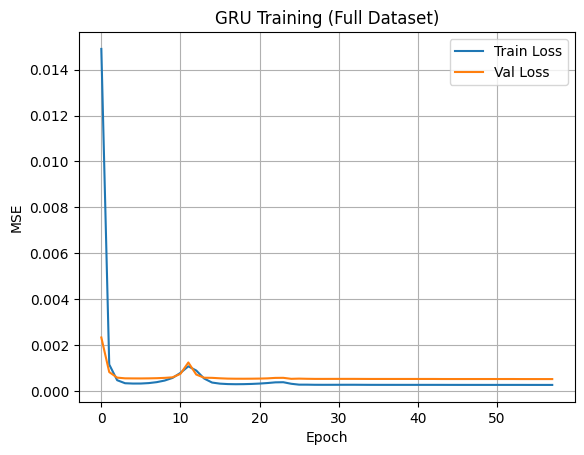


GRU training complete
Mode: Full Dataset


In [20]:
from models.gru import build_gru_forecaster_augmented
from models.lstm import EncodedLatentSequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# gru config
TRAIN_ON_FULL_DATA = True

# patch encoder and create sequence generators
vae_model.encoder.predict = lambda x, **kwargs: vae_model.encoder(x, training=False)[1]

full_gru_gen = EncodedLatentSequence(full_dataset_gru, vae_model.encoder)
train_gru_gen = EncodedLatentSequence(train_gru_dataset, vae_model.encoder)
val_gru_gen = EncodedLatentSequence(val_gru_dataset, vae_model.encoder)

# build gru model
sample_gen = full_gru_gen if TRAIN_ON_FULL_DATA else train_gru_gen
sample_batch = sample_gen[0]
input_dim = sample_batch[0].shape[-1]

gru_model = build_gru_forecaster_augmented(
  lookback=LOOKBACK,
  input_dim=input_dim,
  latent_dim=LATENT_DIM,
  lr=5e-4
)

callbacks_gru = [
  EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True, min_delta=1e-5),
  ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
  ModelCheckpoint("saved_models/vae_gru_moe/gru_temporal.weights.h5",
                  monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

print(f"GRU Training Configuration:")
print(f"Training mode: {'Full Dataset' if TRAIN_ON_FULL_DATA else 'Temporal Splits'}")
print(f"Input dim: {input_dim}")

if TRAIN_ON_FULL_DATA:
  # extract arrays for validation split
  print(f"Full dataset batches: {len(full_gru_gen)}")
  
  X_full_list, y_full_list = [], []
  for i in range(len(full_gru_gen)):
      zf_batch, z_target_batch = full_gru_gen[i]
      X_full_list.append(ops.convert_to_numpy(zf_batch))
      y_full_list.append(ops.convert_to_numpy(z_target_batch))
  
  X_full = np.concatenate(X_full_list, axis=0)
  y_full = np.concatenate(y_full_list, axis=0)
  print(f"Full data shape: {X_full.shape} → {y_full.shape}")
  
  # train with validation split
  history_gru = gru_model.fit(
      X_full, y_full,
      validation_split=0.2,
      batch_size=BATCH_SIZE,
      epochs=300,
      shuffle=False,
      callbacks=callbacks_gru,
      verbose=1
  )
else:
  # train with split generators
  print(f"Train batches: {len(train_gru_gen)}")
  print(f"Val batches: {len(val_gru_gen)}")
  
  history_gru = gru_model.fit(
      train_gru_gen,
      validation_data=val_gru_gen,
      epochs=300,
      callbacks=callbacks_gru,
      verbose=1
  )

# save model
gru_model.save("saved_models/vae_gru_moe/gru_temporal.keras")

# plot training
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Val Loss") 
plt.title(f"GRU Training ({'Full Dataset' if TRAIN_ON_FULL_DATA else 'Temporal Splits'})")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

print(f"\nGRU training complete")
print(f"Mode: {'Full Dataset' if TRAIN_ON_FULL_DATA else 'Temporal Splits'}")

Index alignment check:
Z_vae shape: (1258, 12)
Z_pred_gru shape: (1216, 12)
Taking Z_vae[42:1258] for alignment


model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  GRU-VAE          0.004884            0.004884            0.015567   

   acf_diff_mean  var_ratio_pred/true  
0       0.001034             1.003851

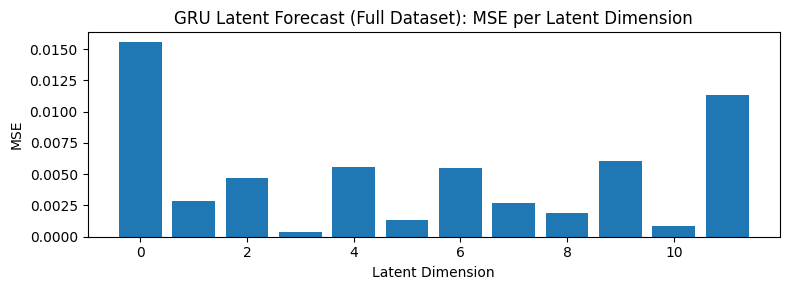

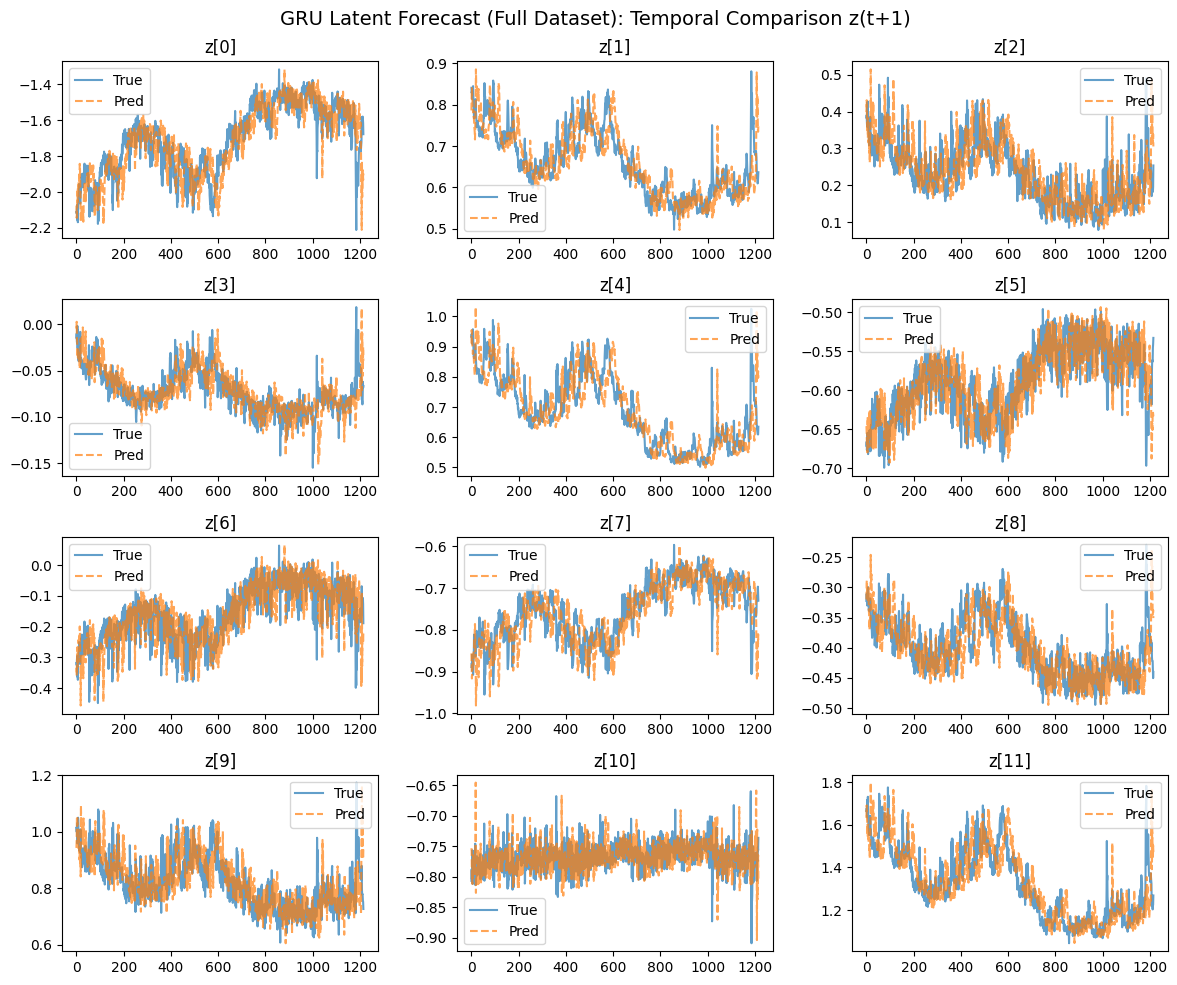

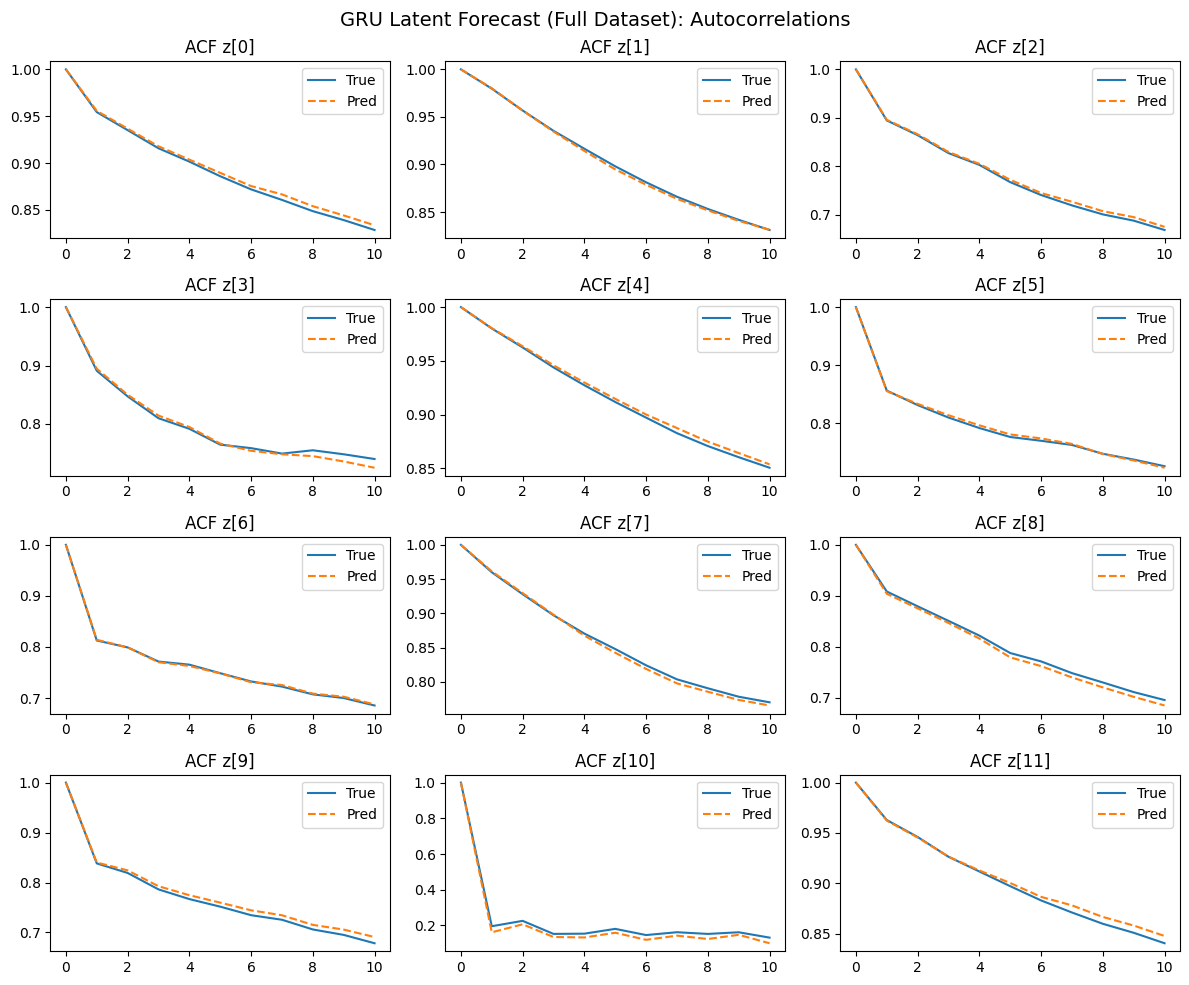

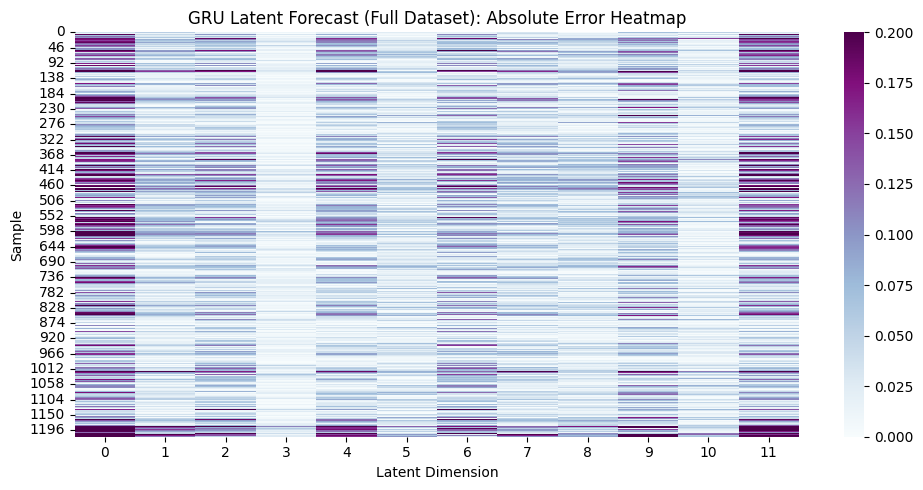

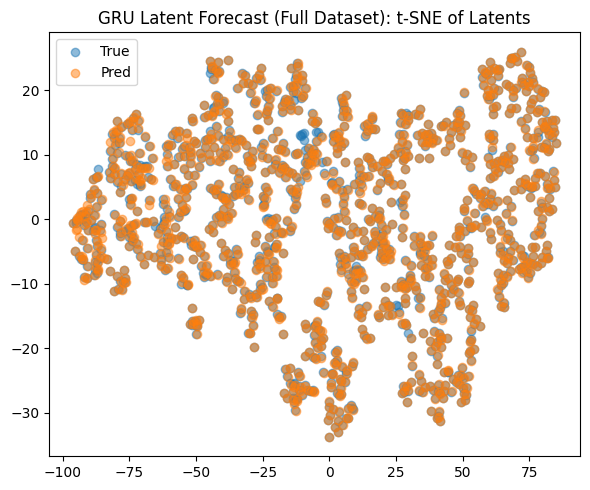

In [21]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

# gru latent forecasting evaluation

# get gru predictions
if TRAIN_ON_FULL_DATA:
  eval_name = "GRU Latent Forecast (Full Dataset)"
  
  if 'X_full' in locals() and 'y_full' in locals():
      X_eval_gru = X_full
      y_eval_gru = y_full
  else:
      eval_gen = EncodedLatentSequence(full_dataset_gru, vae_model.encoder)
      X_eval_list, y_eval_list = [], []
      for i in range(len(eval_gen)):
          zf_batch, z_target_batch = eval_gen[i]
          X_eval_list.append(ops.convert_to_numpy(zf_batch))
          y_eval_list.append(ops.convert_to_numpy(z_target_batch))
      
      X_eval_gru = np.concatenate(X_eval_list, axis=0)
      y_eval_gru = np.concatenate(y_eval_list, axis=0)
else:
  eval_name = "GRU Latent Forecast (Test Split)"
  eval_gen = EncodedLatentSequence(test_gru_dataset, vae_model.encoder)
  
  X_eval_list, y_eval_list = [], []
  for i in range(len(eval_gen)):
      zf_batch, z_target_batch = eval_gen[i]
      X_eval_list.append(ops.convert_to_numpy(zf_batch))
      y_eval_list.append(ops.convert_to_numpy(z_target_batch))

  X_eval_gru = np.concatenate(X_eval_list, axis=0)
  y_eval_gru = np.concatenate(y_eval_list, axis=0)

Z_pred_gru = gru_model.predict(X_eval_gru, verbose=0)

# check alignment
print(f"Index alignment check:")
print(f"Z_vae shape: {Z_vae.shape}")
print(f"Z_pred_gru shape: {Z_pred_gru.shape}")

z_start_idx = len(Z_vae) - len(Z_pred_gru)
z_end_idx = len(Z_vae)
print(f"Taking Z_vae[{z_start_idx}:{z_end_idx}] for alignment")

# align
Z_true_gru = Z_vae[-len(Z_pred_gru):]

# evaluation
from utils.eval import summarize_latent_errors
summary_gru = summarize_latent_errors(Z_true_gru, Z_pred_gru, name="GRU-VAE")
display(summary_gru)

plot_latent_diagnostics(Z_true_gru, Z_pred_gru, name=eval_name, tsne=True)

Aligned shapes:
Y_true: (1216, 11, 10)
Y_pred: (1216, 11, 10)
GRU-VAE RMSE: 0.022375
Evaluation dimensions: N=1216, M=11, K=10
GRU→VAE Pipeline RMSE_σ: 0.0205
RMSE by maturity (mean ± std): 0.0212 ± 0.0072
RMSE by strike    (mean ± std): 0.0219 ± 0.0046
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


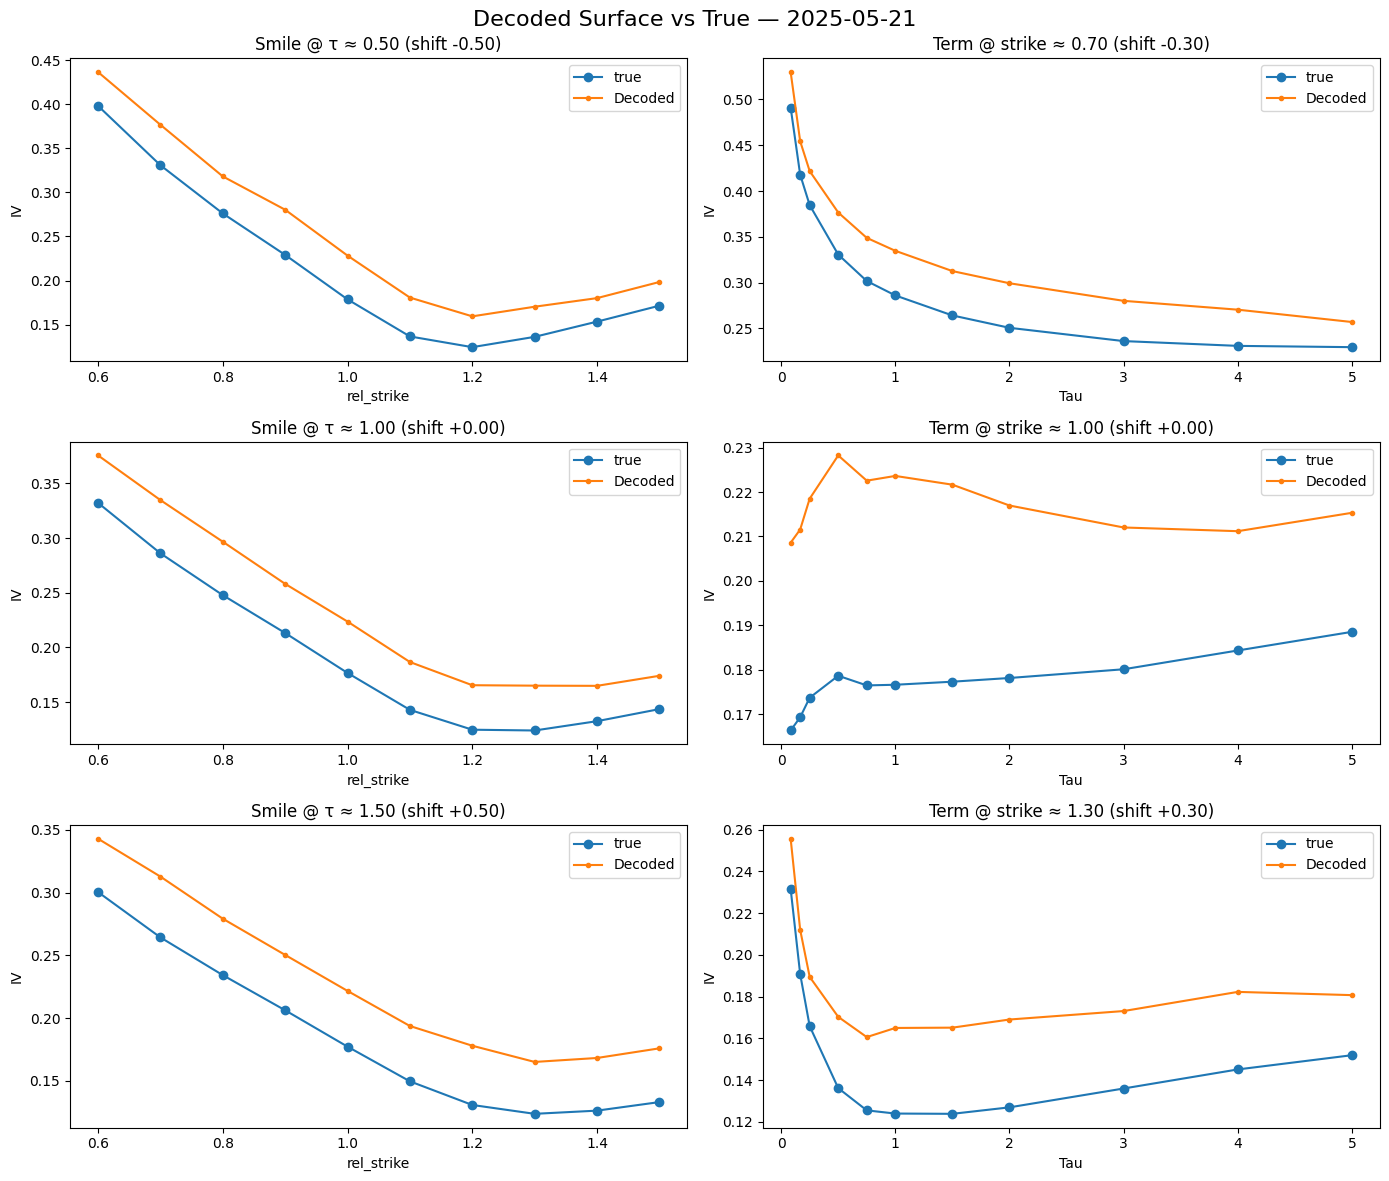

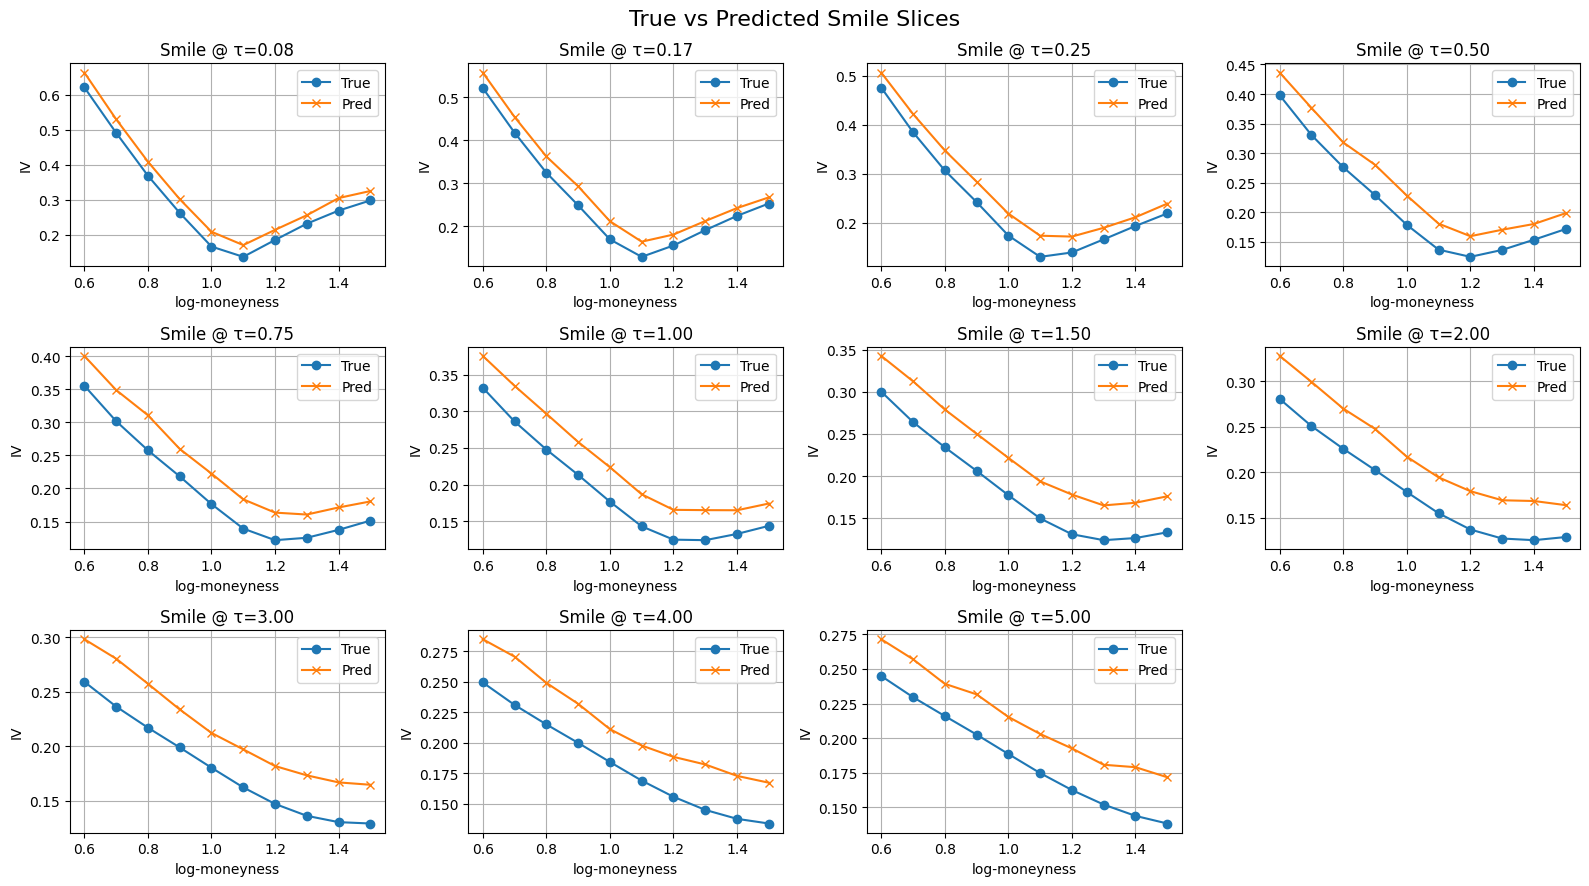

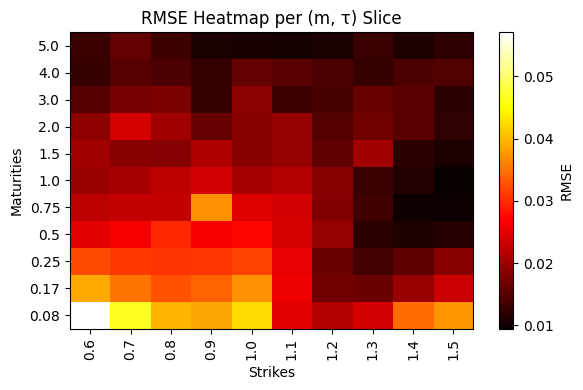

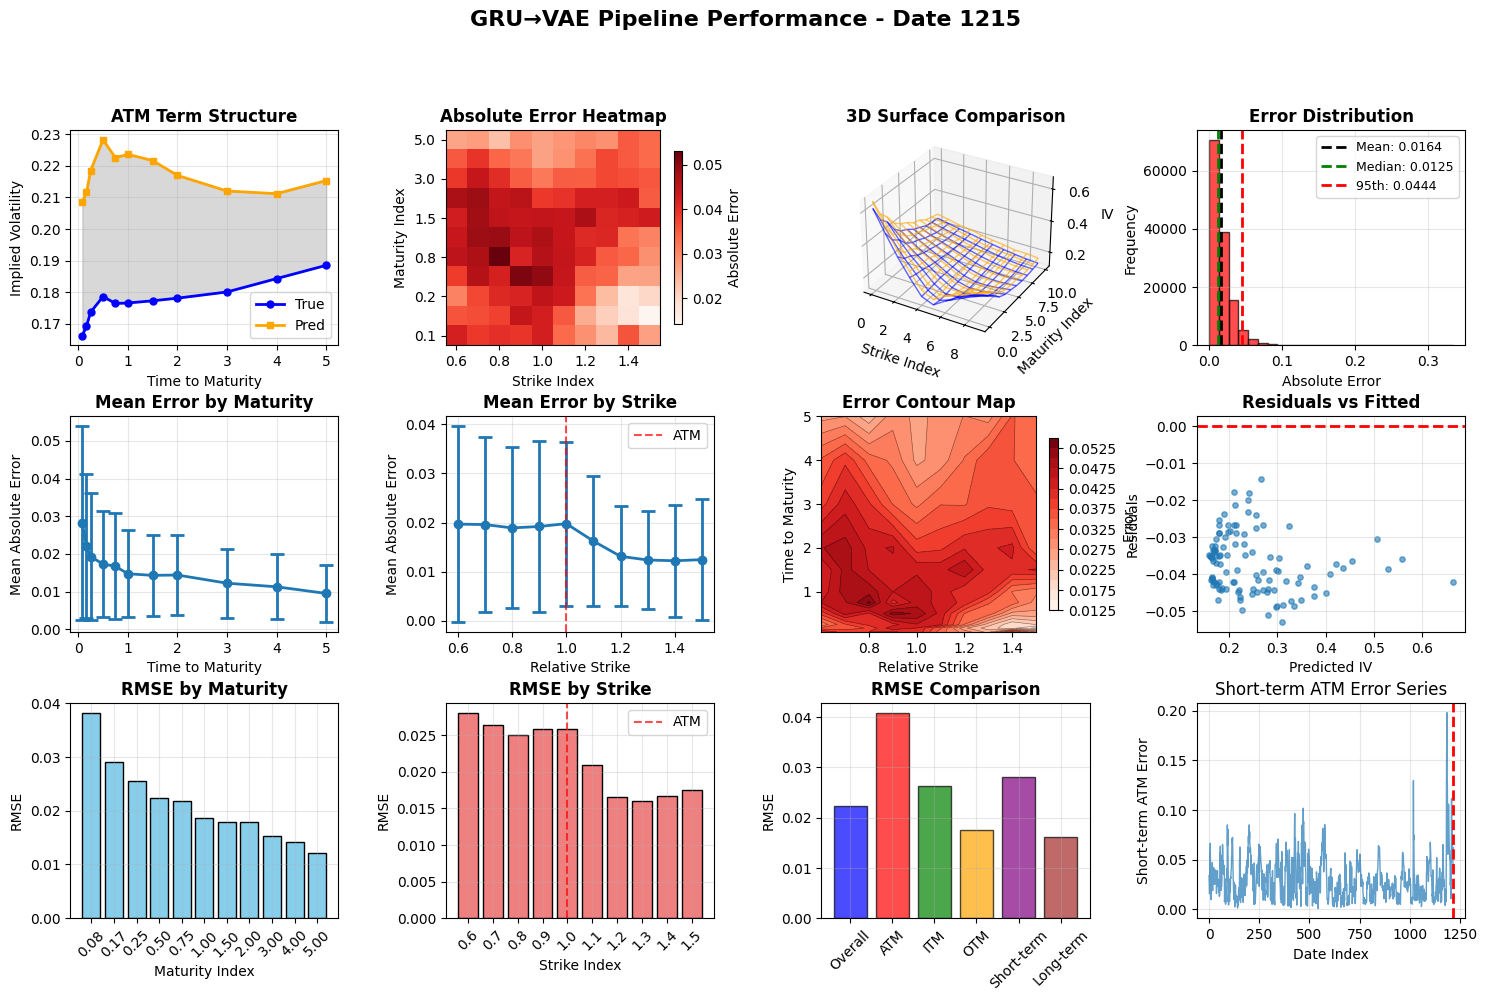

Overall Performance Category Performance  \
RMSE                           0.022375                  NaN   
MAE                            0.016359                  NaN   
Max Error                      0.333760                  NaN   
Mean Error                     0.016359                  NaN   
Median Error                   0.012503                  NaN   
95th Percentile                0.044430                  NaN   
ATM RMSE                            NaN             0.040810   
ITM RMSE                            NaN             0.026369   
OTM RMSE                            NaN             0.017637   
Short-term RMSE                     NaN             0.028059   
Long-term RMSE                      NaN             0.016180   
Short/Long Ratio                    NaN                1.734   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.012160)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.038157)                       NaN  
Best Strike           K=1.3 (RMSE: 0.015965)                       NaN  
Worst Strike          K=0.6 (RMSE: 0.028025)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.025886)                       NaN  
Overall Rank              ATM ranks #6 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.734)  
ATM Issues                               NaN  YES (ATM/Overall: 1.82x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.008732)  
High Error Variance                      NaN       YES (std: 0.015266)  
Model Quality                            NaN                      FAIR  
Recommendation                           NaN         Needs Improvement


PCA-VAR: 0.016563
GRU-VAE: 0.022375
Improvement: -35.10%


In [23]:
from utils.eval import evaluate_decoder_output_v2
from utils.plot_error import analyze_decoder_comprehensive

# decode gru predictions
YF_recon_vae = vae_model.decoder.predict(Z_pred_gru, verbose=0)[0]
Y_prime_flat = YF_recon_vae[:, :SURFACE_DIM]
Y_prime = Y_prime_flat.reshape(-1, M, K)

# ground truth alignment
Y = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]
Y_flat = Y.reshape(T, M * K).astype(np.float64)

YF_combined = ops.convert_to_numpy(YF_full_vae)
valid_mask = np.all(np.isfinite(YF_combined), axis=1)
Y_surface_valid = Y_flat[valid_mask]
Y_true_flat_aligned = Y_surface_valid[-len(Z_pred_gru):]
Y_true_aligned = Y_true_flat_aligned.reshape(-1, M, K)

# metrics
rmse_gru_vae = np.sqrt(np.mean((Y_true_flat_aligned - Y_prime_flat)**2))

print(f"Aligned shapes:")
print(f"Y_true: {Y_true_aligned.shape}")
print(f"Y_pred: {Y_prime.shape}")
print(f"GRU-VAE RMSE: {rmse_gru_vae:.6f}")

# evaluation
evaluate_decoder_output_v2(
  Y_pred=Y_prime,
  Y_true=Y_true_aligned,
  tensors=tensors,
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  taus=ops.convert_to_numpy(tensors["taus"]),
  target_date=TARGET_DATE,
  target_tau=TARGET_TAU,
  target_strike=TARGET_STRIKE,
  decoder=None,
  title="GRU→VAE Pipeline"
)

analyze_decoder_comprehensive(
  Y_true=Y_true_aligned,
  Y_pred=Y_prime,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="GRU→VAE Pipeline Performance"
)

# comparison
if 'rmse_pca' in locals():
  improvement = ((rmse_pca - rmse_gru_vae) / rmse_pca * 100)
  print(f"\nPCA-VAR: {rmse_pca:.6f}")
  print(f"GRU-VAE: {rmse_gru_vae:.6f}") 
  print(f"Improvement: {improvement:.2f}%")

----
----

## LATENT INPUT/CORRELATIONS AWARE 

---
---

In [61]:
# insert black and scholes loss
hybrid_loss_fn, vega_weights, gamma_weights = create_black_scholes_hybrid_loss(
  taus, rel_strikes, M, K, 
  mse_weight=0.5, vega_weight=0.2, gamma_weight=0.3
)


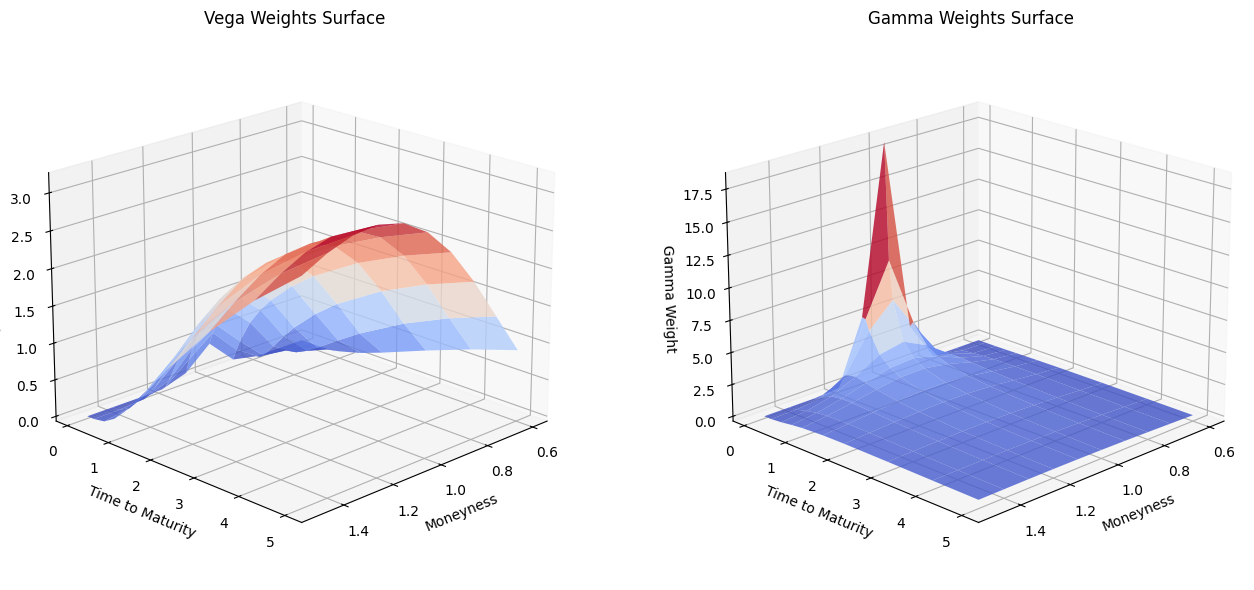

In [62]:
# collect weights
weight_data = []
for i in range(M):
  for j in range(K):
      idx = i * K + j
      weight_data.append({
          'tau': taus[i],
          'strike': rel_strikes[j],
          'vega_weight': vega_weights[idx],
          'gamma_weight': gamma_weights[idx]
      })

weight_df = pd.DataFrame(weight_data)

# 3d surface plots with actual values
fig = plt.figure(figsize=(14, 6))

# create meshgrid with actual tau and strike values
strike_mesh, tau_mesh = np.meshgrid(rel_strikes, taus)

# vega surface
ax1 = fig.add_subplot(121, projection='3d')
vega_surface = weight_df.pivot_table(index='tau', columns='strike', values='vega_weight').values
ax1.plot_surface(strike_mesh, tau_mesh, vega_surface, cmap='coolwarm', alpha=0.8)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Vega Weight')
ax1.set_title('Vega Weights Surface')
ax1.view_init(elev=20, azim=45)

# gamma surface
ax2 = fig.add_subplot(122, projection='3d')
gamma_surface = weight_df.pivot_table(index='tau', columns='strike', values='gamma_weight').values
ax2.plot_surface(strike_mesh, tau_mesh, gamma_surface, cmap='coolwarm', alpha=0.8)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Gamma Weight')
ax2.set_title('Gamma Weights Surface')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

In [97]:
# moe decoder setup

import importlib
import models.pointwise_moe
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras import ops
import numpy as np

# surface+market features
F_full_tensor = X_feat_tensor
YF_combined = ops.convert_to_numpy(YF_full_vae)
valid_mask = np.all(np.isfinite(YF_combined), axis=1)
F_valid_full = F_full_tensor[valid_mask]
Y_prime_F = F_valid_full[-len(Z_pred_gru):]  # (n, 136)

# latents
Z_latents = Z_pred_gru  # (n, 12)

# grid
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])

num_experts = 7
Maturity_experts = 4
free_experts = num_experts - Maturity_experts

# decoder
decoder_pw_mod = PiecewiseSurfaceDecoderModular(
  latent_dim=12,
  M=M, K=K, 
  taus=taus,
  feature_dim=Y_prime_F.shape[1],  # 136
  activation="gelu",
  use_moe=True,
  num_experts=num_experts,
  maturity_experts=Maturity_experts,
  free_experts=free_experts,
  maturity_specialization=True,
  atm_specialization=False,
  lambda_diversity=1,
)

# targets
Y_surface_full = Y_true_aligned.reshape(-1, M * K)

# splits
gru_start_global = len(tensors["date_tensor"]) - len(Z_latents)
train_end_in_gru = train_idx[-1] - gru_start_global + 1
val_end_in_gru = val_idx[-1] - gru_start_global + 1

train_split = min(train_end_in_gru, len(Z_latents))
val_split = min(val_end_in_gru, len(Z_latents))

Z_latents_train, Z_latents_val, Z_latents_test = np.split(Z_latents, [train_split, val_split])
Y_prime_F_train, Y_prime_F_val, Y_prime_F_test = np.split(Y_prime_F, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

# pointwise data
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_test
)

X_train = [X_zf_train, X_m_train, X_tau_train]
X_val = [X_zf_val, X_m_val, X_tau_val]
X_test = [X_zf_test, X_m_test, X_tau_test]

# check
total_indices = np.arange(len(tensors["date_tensor"]))
total_dates = ops.convert_to_numpy(tensors["date_tensor"])
gru_global_indices = total_indices[-len(Z_latents):]

print(f"moe verification (12-dim)")
print(f"z: {Z_latents.shape} yf: {Y_prime_F.shape} y: {Y_true_aligned.shape}")
print(f"range: [{gru_global_indices[0]}, {gru_global_indices[-1]}]")
print(f"splits: train {Z_latents_train.shape[0]} val {Z_latents_val.shape[0]} test {Z_latents_test.shape[0]}")
print(f"samples: {sum(x[0].shape[0] for x in [X_train, X_val, X_test])}")
print(f"dims: {Z_latents.shape[1]} + {Y_prime_F.shape[1]} = {Z_latents.shape[1] + Y_prime_F.shape[1]}")
print(f"x_train shape: {X_train[0].shape}")

Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
moe verification (12-dim)
z: (1216, 12) yf: torch.Size([1216, 136]) y: (1216, 11, 10)
range: [42, 1257]
splits: train 838 val 189 test 189
samples: 133760
dims: 12 + 136 = 148
x_train shape: (92180, 148)


initial biases (progress=0.0):
bias levels: max=12.0, moderate=4.0


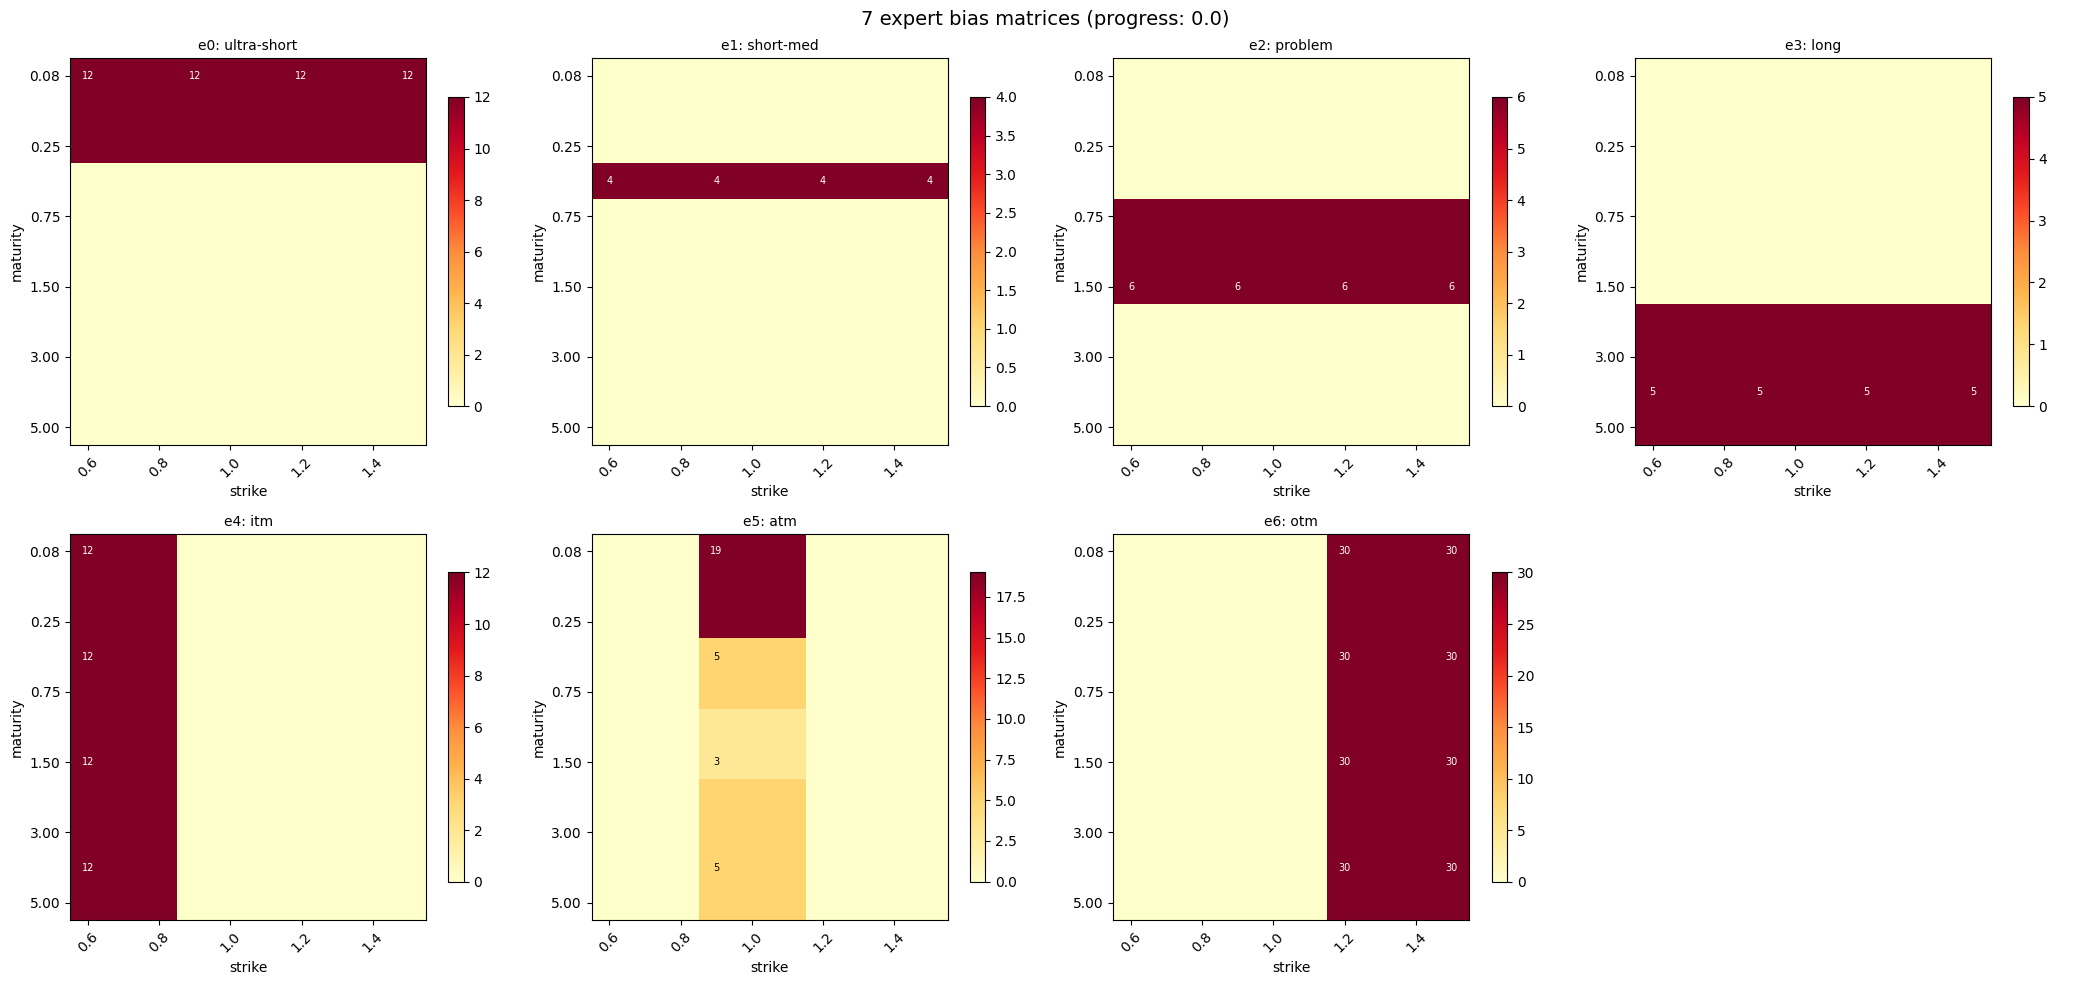


expert bias summary:
e0: ultra-short | active:  30/110 (27.3%) | max:  12.0 | avg:  12.0
e1: short-med   | active:  10/110 ( 9.1%) | max:   4.0 | avg:   4.0
e2: problem     | active:  30/110 (27.3%) | max:   6.0 | avg:   6.0
e3: long        | active:  40/110 (36.4%) | max:   5.0 | avg:   5.0
e4: itm         | active:  33/110 (30.0%) | max:  12.0 | avg:  12.0
e5: atm         | active:  33/110 (30.0%) | max:  19.0 | avg:   8.5
e6: otm         | active:  44/110 (40.0%) | max:  30.0 | avg:  30.0
bias levels: max=12.0, moderate=4.0

verifying decoder configuration:
num_experts: 7
maturity_experts: 4
free_experts: 3
maturity_specialization: True
lambda_diversity: 1


In [98]:
# visualize moe expert biases vs the various stages of the annealing progress to see where 
# weights need to be improved

import models.decoder_losses
importlib.reload(models.decoder_losses)


from utils.moe_weights import plot_expert_bias_matrices, calculate_expert_bias_matrix

# check bias configuration at different training stages
print("initial biases (progress=0.0):")
plot_expert_bias_matrices(
   calendar_multiplier=2.5,
   strike_bands=[0.9, 1.1],
   progress=0.0,
   figsize=(21, 10)
)


# get raw bias matrices for inspection
expert_biases, taus, strikes = calculate_expert_bias_matrix(
   calendar_multiplier=1.5,
   strike_bands=[0.9, 1.1],
   progress=0.0
)

print("\nverifying decoder configuration:")
print(f"num_experts: {decoder_pw_mod.num_experts}")
print(f"maturity_experts: {decoder_pw_mod.maturity_experts}")
print(f"free_experts: {decoder_pw_mod.free_experts}")
print(f"maturity_specialization: {decoder_pw_mod.maturity_specialization}")
print(f"lambda_diversity: {decoder_pw_mod.lambda_diversity}")

moe pipeline: gru -> z_latents + y_prime_f -> moe -> y_hat
input: z(12) + yf(136) = 148 dims
training: 92180 samples
Epoch 1/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 4.4260 - val_loss: 1.1983 - learning_rate: 1.0000e-04
Epoch 2/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 55s 38ms/step - loss: 0.9476 - val_loss: 0.5362 - learning_rate: 1.0000e-04
Epoch 3/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 0.3778 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 4/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - loss: 0.1610 - val_loss: 0.1180 - learning_rate: 1.0000e-04
Epoch 5/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - loss: 0.0995 - val_loss: 0.0896 - learning_rate: 1.0000e-04
Epoch 6/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - loss: 0.0729 - val_loss: 0.0677 - learning_rate: 1.0000e-04
Epoch 7/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - loss: 0.0578 - val_loss: 0.0547 - learning_rate: 1.0000e-04
Epoch 8/100
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 51s 35m

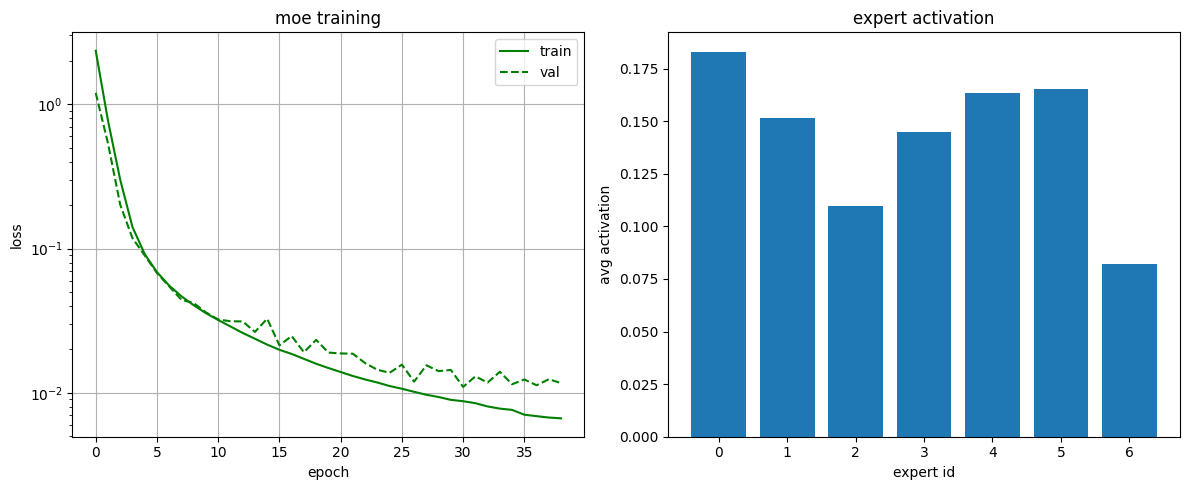

In [99]:
# training

import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# loss
import models.decoder_losses
importlib.reload(models.decoder_losses)




# compile
decoder_pw_mod.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# callbacks
save_dir = "saved_models/vae_gru_moe"
os.makedirs(save_dir, exist_ok=True)
callbacks = [
  EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, min_delta=1e-5),
  ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=4, min_lr=1e-7),
  ModelCheckpoint(f"{save_dir}/decoder_final.keras", save_best_only=True, verbose=0)
]

print(f"moe pipeline: gru -> z_latents + y_prime_f -> moe -> y_hat")
print(f"input: z({Z_latents.shape[1]}) + yf({Y_prime_F.shape[1]}) = {X_train[0].shape[1]} dims")
print(f"training: {X_train[0].shape[0]} samples")

# fit
history = decoder_pw_mod.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=64, # set 256 25min for speed best results 32 , 2-3 hours
  epochs=100,
  callbacks=callbacks,
  verbose=1
)

decoder_pw_mod.save(f"{save_dir}/decoder_final.keras")
print(f"train: {history.history['loss'][-1]:.6f} | val: {history.history['val_loss'][-1]:.6f}")

# plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train", color='green')
plt.plot(history.history["val_loss"], label="val", color='green', linestyle='--')
plt.title("moe training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.subplot(1, 2, 2)
analysis = decoder_pw_mod.analyze_gating(X_val)
if analysis is not None:
   plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
   plt.title("expert activation")
   plt.xlabel("expert id")
   plt.ylabel("avg activation")
   plt.xticks(range(decoder_pw_mod.num_experts))
   
   print(f"\nexpert analysis:")
   print(f"  activations: {analysis['expert_activations']}")
   print(f"  entropy: {analysis['gate_entropy'].mean():.3f}")
   active = (np.array(analysis['expert_activations']) > 0.05).sum()
   print(f"  active: {active}/{decoder_pw_mod.num_experts}")

plt.tight_layout()
plt.show()

evaluating on test set
  1/650 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step

650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Evaluation dimensions: N=189, M=11, K=10
moe 12-dim latent - test set RMSE_σ: 0.0103
RMSE by maturity (mean ± std): 0.0110 ± 0.0055
RMSE by strike    (mean ± std): 0.0117 ± 0.0040
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


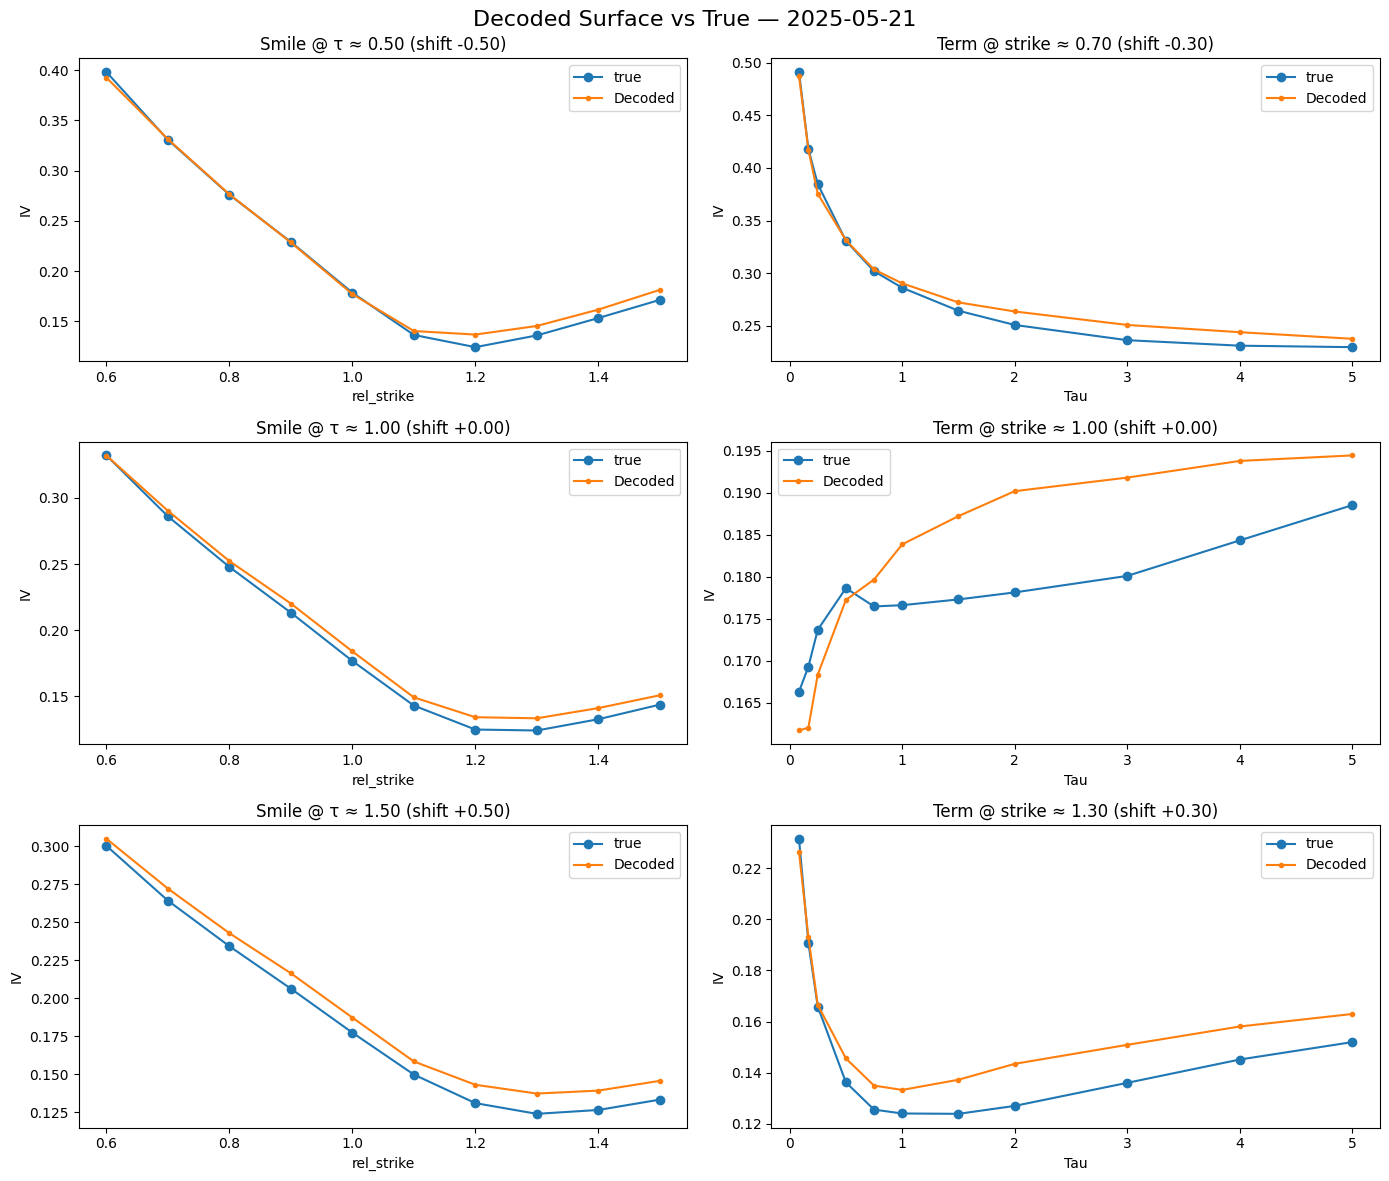

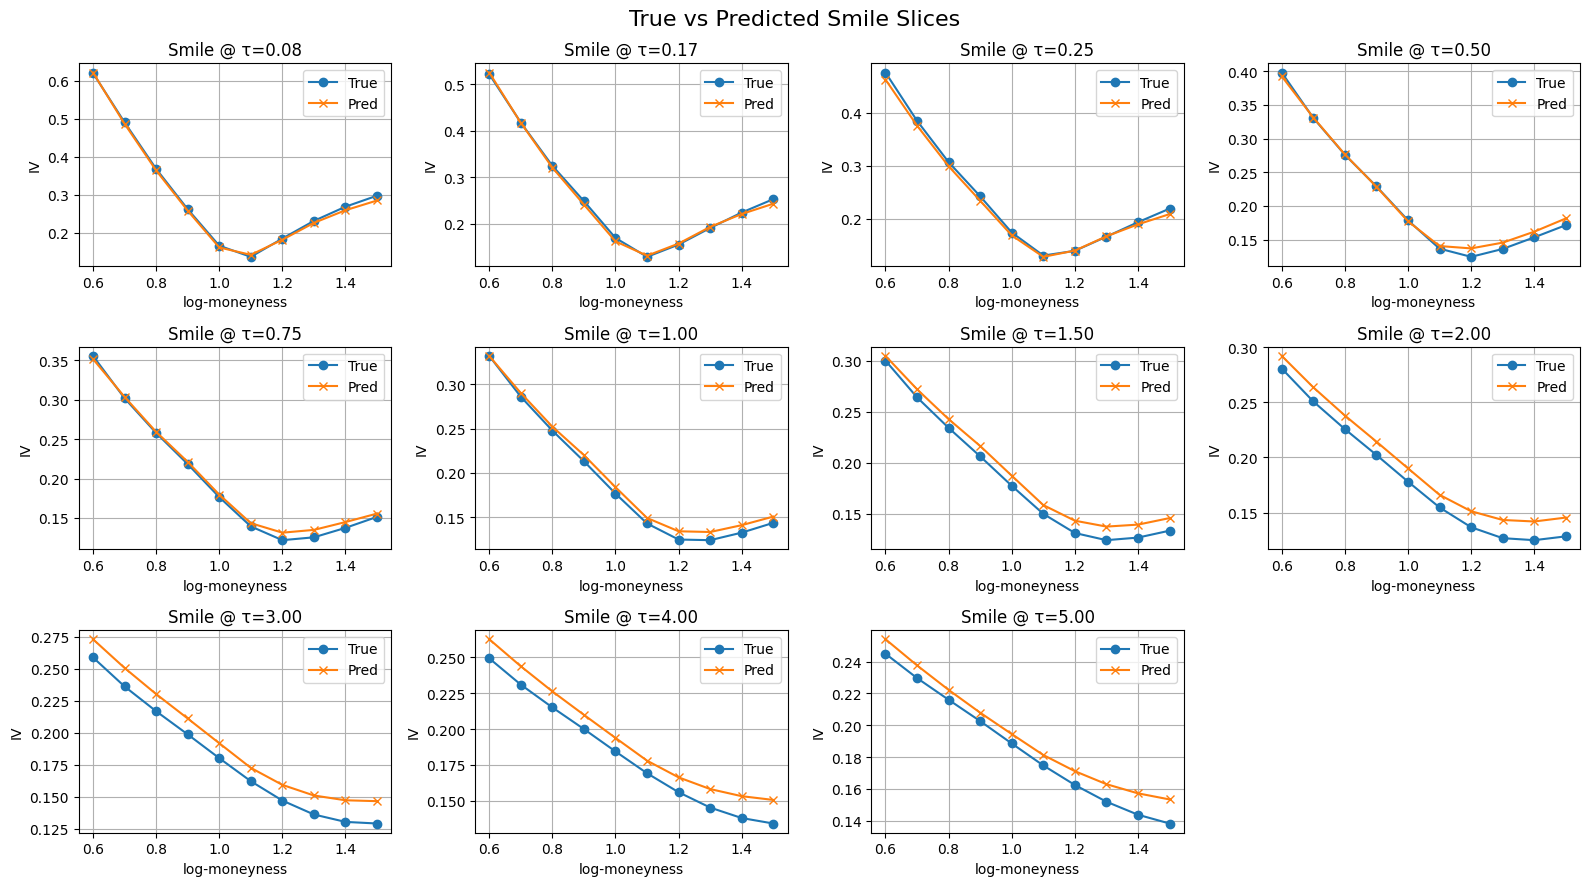

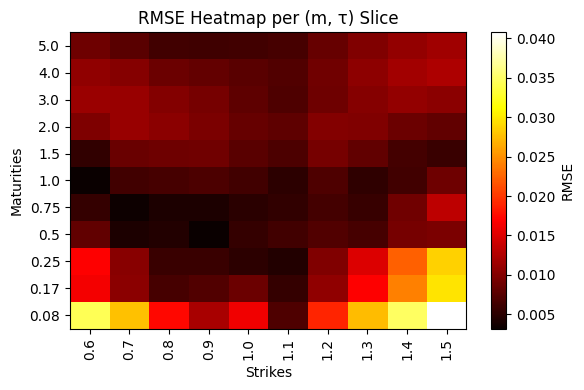

MoE Analysis
Experts: 7
Diversity: 1


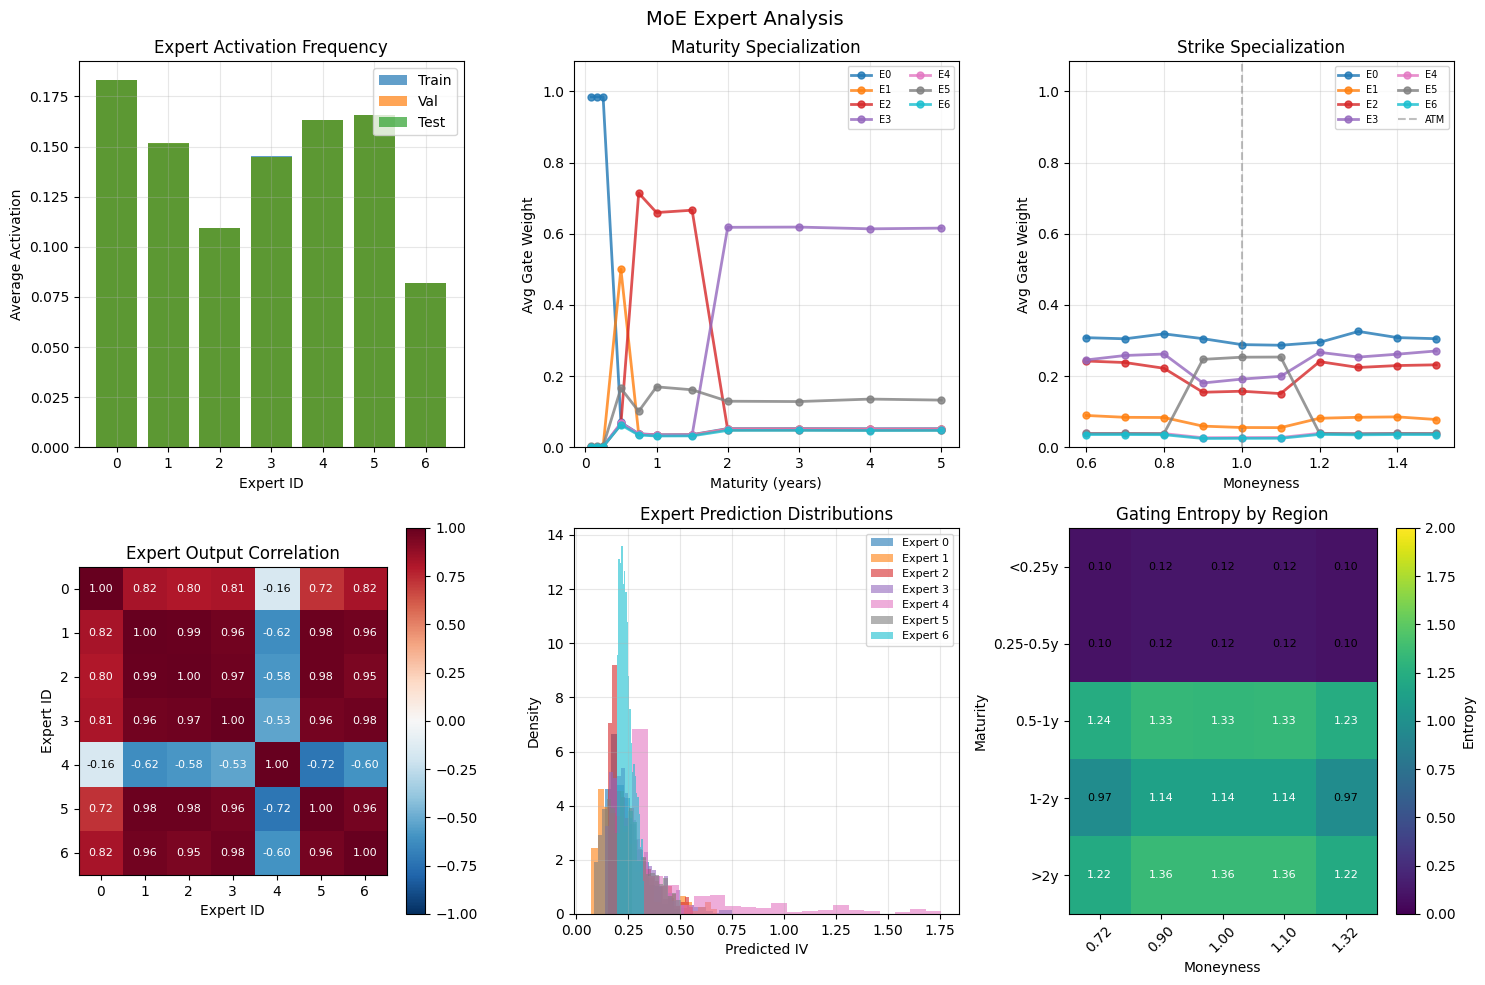


Summary:
Most active expert: 0
Least active expert: 6
Balance score: 0.967
Avg entropy: 1.918
Min correlation: -0.721
Max correlation: 1.000


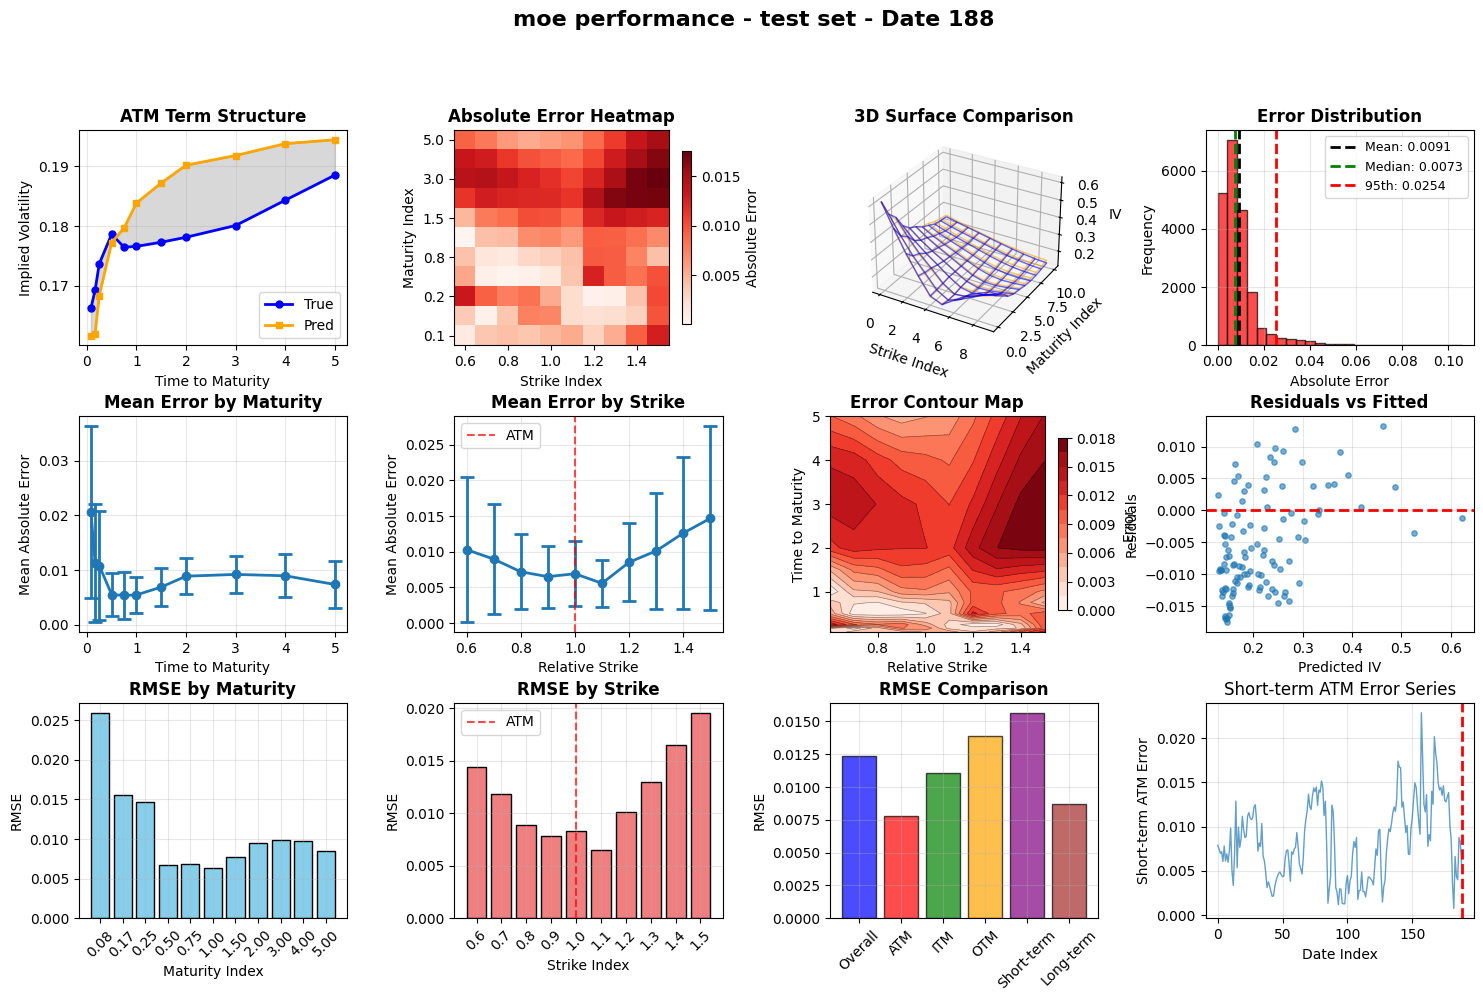

Overall Performance Category Performance  \
RMSE                           0.012344                  NaN   
MAE                            0.009133                  NaN   
Max Error                      0.105807                  NaN   
Mean Error                     0.009133                  NaN   
Median Error                   0.007302                  NaN   
95th Percentile                0.025370                  NaN   
ATM RMSE                            NaN             0.007818   
ITM RMSE                            NaN             0.011061   
OTM RMSE                            NaN             0.013899   
Short-term RMSE                     NaN             0.015631   
Long-term RMSE                      NaN             0.008703   
Short/Long Ratio                    NaN                1.796   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.00 (RMSE: 0.006383)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.025889)                       NaN  
Best Strike           K=1.1 (RMSE: 0.006475)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.019539)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.008275)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.796)  
ATM Issues                               NaN   NO (ATM/Overall: 0.63x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.002838)  
High Error Variance                      NaN       YES (std: 0.008304)  
Model Quality                            NaN                      GOOD  
Recommendation                           NaN         Needs Improvement


rmse: 0.012344
vs gru-vae: 44.83% improvement


In [100]:
# eval

import models.pointwise_moe
import utils.eval
import utils.plot_error
import importlib
importlib.reload(models.pointwise_moe)
importlib.reload(utils.eval)
importlib.reload(utils.plot_error)

from utils.eval import evaluate_decoder_output_v2, analyze_moe_training_performance
from utils.plot_error import analyze_decoder_comprehensive

# config
EVAL_ON_TEST_ONLY = True

if EVAL_ON_TEST_ONLY:
  print("evaluating on test set")
  Z_eval = Z_latents_test
  Y_prime_F_eval = Y_prime_F_test
  Y_true_eval = Y_test.reshape(-1, M, K)
  eval_title = "test set"
else:
  print("evaluating on full dataset")
  Z_eval = Z_latents
  Y_prime_F_eval = Y_prime_F
  Y_true_eval = Y_true_aligned
  eval_title = "full dataset"

# grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# predictions
Z_eval_np = ops.convert_to_numpy(Z_eval) if hasattr(Z_eval, 'cpu') else Z_eval
Y_prime_F_eval_np = ops.convert_to_numpy(Y_prime_F_eval) if hasattr(Y_prime_F_eval, 'cpu') else Y_prime_F_eval
X_zf_eval = np.concatenate([Z_eval_np, Y_prime_F_eval_np], axis=1)

X_zf_expanded = np.repeat(X_zf_eval, M*K, axis=0)
X_m_expanded = np.tile(m_flat.flatten(), len(Z_eval))[:, None]
X_tau_expanded = np.tile(tau_flat.flatten(), len(Z_eval))[:, None]

y_hat_flat = decoder_pw_mod.predict([X_zf_expanded, X_m_expanded, X_tau_expanded])
Y_hat_moe = y_hat_flat.reshape(-1, M, K)

# evaluate
evaluate_decoder_output_v2(
  Y_pred=Y_hat_moe,
  Y_true=Y_true_eval,
  tensors=tensors,
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  taus=ops.convert_to_numpy(tensors["taus"]),
  target_date=TARGET_DATE,
  target_tau=TARGET_TAU,
  target_strike=TARGET_STRIKE,
  decoder=decoder_pw_mod,
  title=f"moe 12-dim latent - {eval_title}"
)

if EVAL_ON_TEST_ONLY:
  results = analyze_moe_training_performance(
      decoder_pw_mod, X_train, X_val, X_test, 
      y_train, y_val, y_test
  )

metrics = analyze_decoder_comprehensive(
  Y_true=Y_true_eval,
  Y_pred=Y_hat_moe,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title=f"moe performance - {eval_title}"
)

# comparison
rmse_moe = np.sqrt(np.mean((Y_true_eval.reshape(-1) - Y_hat_moe.reshape(-1))**2))
print(f"\nrmse: {rmse_moe:.6f}")

if 'rmse_gru_vae' in locals():
   improvement = ((rmse_gru_vae - rmse_moe) / rmse_gru_vae * 100)
   print(f"vs gru-vae: {improvement:.2f}% improvement")

raw shape: (20, 11, 10)
window size: 5
Evaluation dimensions: N=20, M=11, K=10
refined moe surfaces RMSE_σ: 0.0085
RMSE by maturity (mean ± std): 0.0090 ± 0.0045
RMSE by strike    (mean ± std): 0.0097 ± 0.0029
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


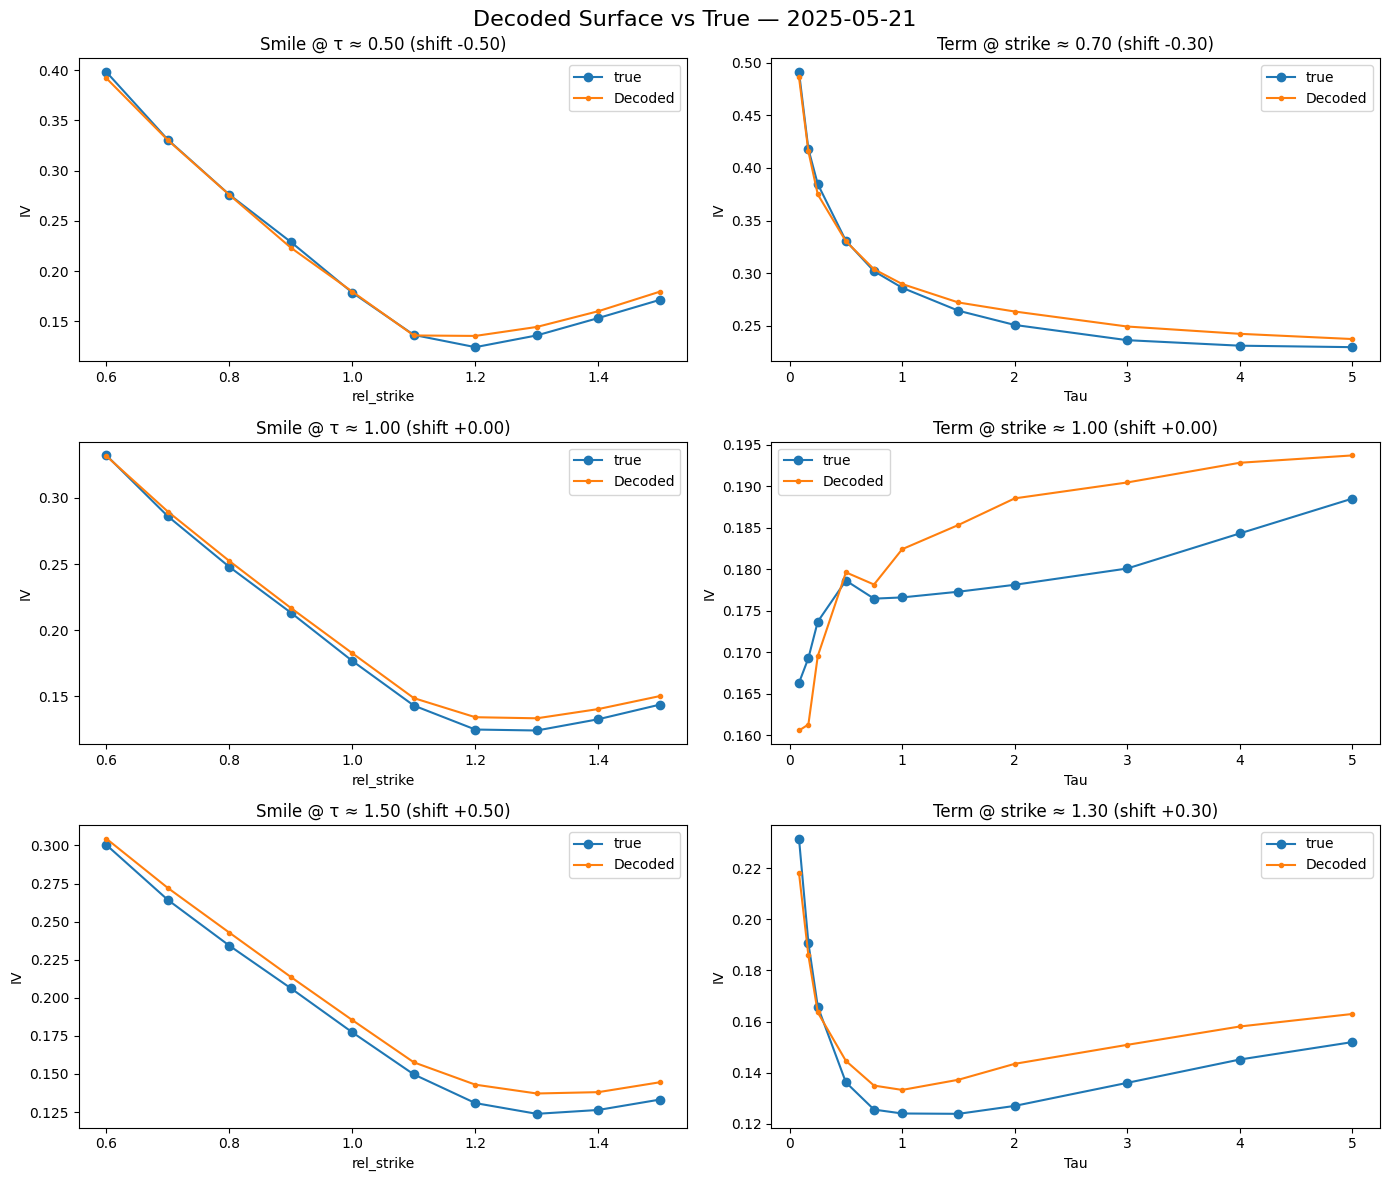

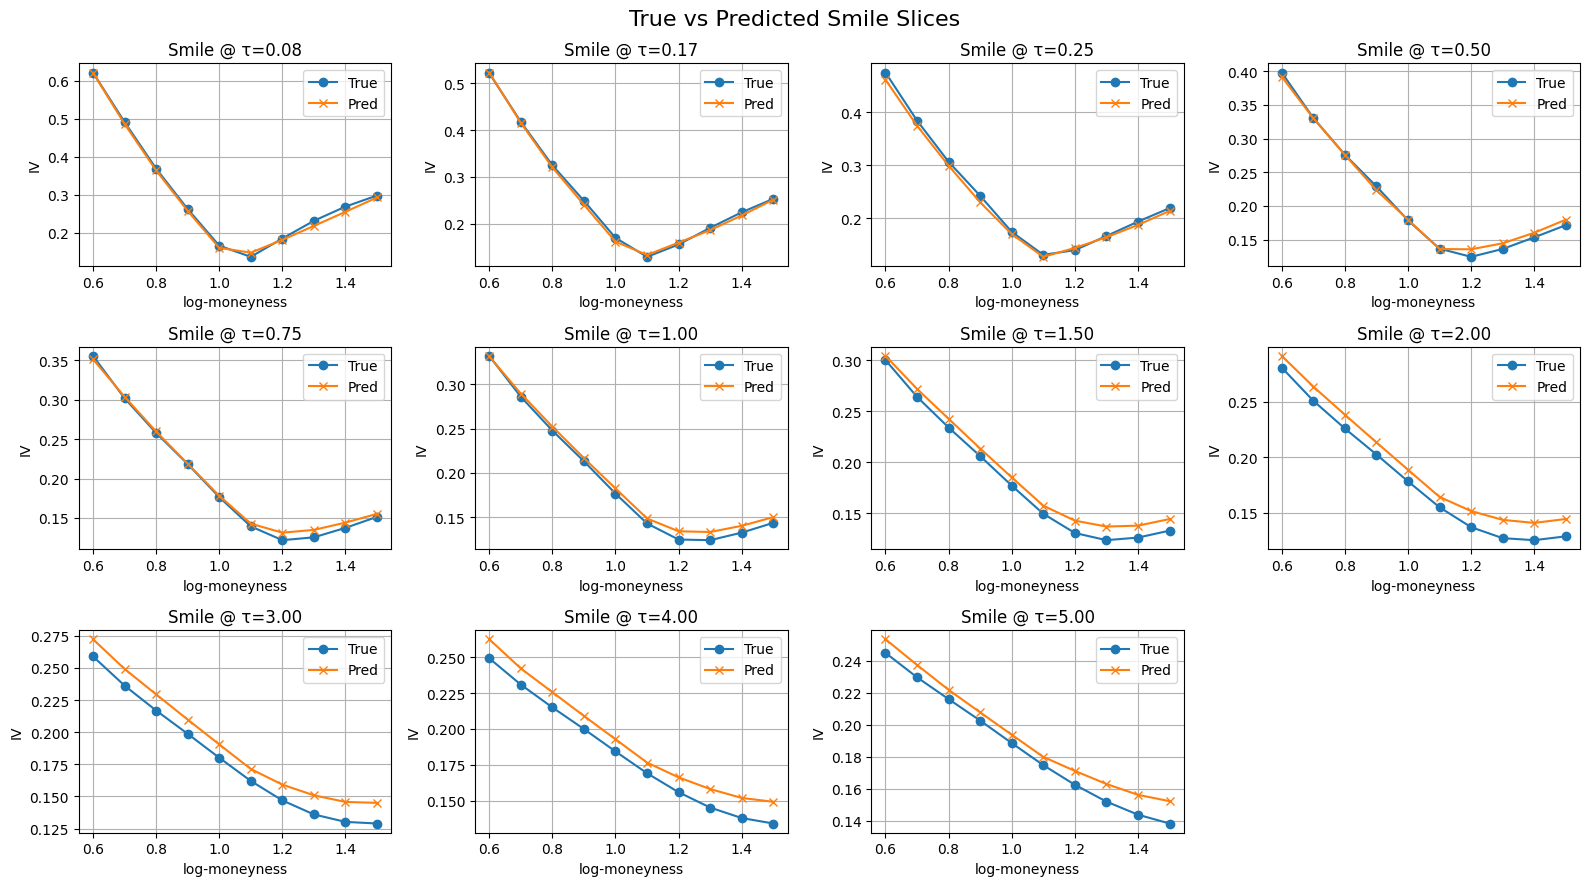

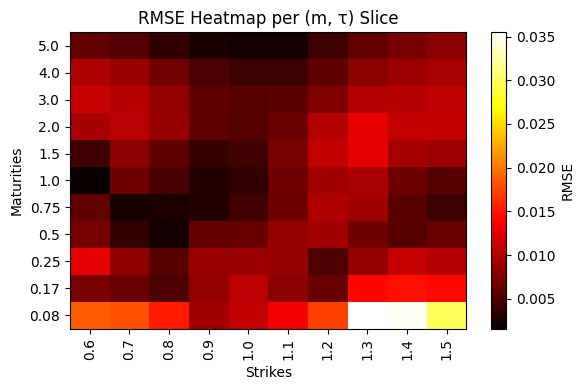


raw rmse: 0.011725
refined rmse: 0.010088
improvement: 13.96%


In [101]:
# surface refinement

import importlib
import utils.eval
importlib.reload(utils.eval)

import models.pointwise_moe
importlib.reload(models.pointwise_moe)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 20

# select data - using consistent names from notebook 2
Z_eval = Z_latents if SMOOTH_ALL else Z_latents[-N_surfaces:]
Y_prime_F_eval = Y_prime_F if SMOOTH_ALL else Y_prime_F[-N_surfaces:]
Y_true_eval = Y_true_aligned if SMOOTH_ALL else Y_true_aligned[-N_surfaces:]

# grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate raw predictions
Y_pred_raw = []
for z, yf in zip(Z_eval, Y_prime_F_eval):
    # prepare inputs
    z_np = ops.convert_to_numpy(z).reshape(1, -1).astype(np.float32)
    yf_np = ops.convert_to_numpy(yf).reshape(1, -1).astype(np.float32)
    zf = np.concatenate([z_np, yf_np], axis=-1)
    
    # expand for pointwise
    zf_repeat = np.repeat(zf, M * K, axis=0)
    m_tensor = ops.convert_to_tensor(m_flat.astype("float32"))
    tau_tensor = ops.convert_to_tensor(tau_flat.astype("float32"))
    
    # predict
    iv = decoder_pw_mod([zf_repeat, m_tensor, tau_tensor], training=False)
    surf = ops.convert_to_numpy(iv).reshape(M, K)
    Y_pred_raw.append(surf)

Y_pred_raw = np.stack(Y_pred_raw)
print(f"raw shape: {Y_pred_raw.shape}")

# prepare ground truth
Y_true_3d = Y_true_eval.reshape(-1, M, K) if len(Y_true_eval.shape) == 2 else Y_true_eval

# sliding window refinement
window_size = max(1, int(N_surfaces // 4))
print(f"window size: {window_size}")

Y_pred_smooth = []
for i, surf in enumerate(Y_pred_raw):
    # recent surfaces window
    window_start = max(0, i - window_size)
    window_end = i + 1
    recent_surfaces = Y_true_3d[window_start:window_end]
    
    # refine
    refined_surf = decoder_pw_mod.refine_surface(
        surf, 
        recent_surfaces=recent_surfaces,
        lambda_cal=0.1,
        lambda_smile=0.1,
        lambda_history=0.05
    )
    Y_pred_smooth.append(refined_surf)

Y_pred_smooth = np.stack(Y_pred_smooth)

# evaluate
evaluate_decoder_output_v2(
    Y_pred=Y_pred_smooth,
    Y_true=Y_true_eval,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,
    title="refined moe surfaces"
)

# compare raw vs refined
rmse_raw = np.sqrt(np.mean((Y_true_3d - Y_pred_raw)**2))
rmse_smooth = np.sqrt(np.mean((Y_true_3d - Y_pred_smooth)**2))
print(f"\nraw rmse: {rmse_raw:.6f}")
print(f"refined rmse: {rmse_smooth:.6f}")
print(f"improvement: {((rmse_raw - rmse_smooth) / rmse_raw * 100):.2f}%")

---
### ADAPTIVE IMPLEMENTATION
---

In [146]:
# moe decoder setup

import importlib
import models.pointwise_moe
importlib.reload(models.pointwise_moe_adpt)

from models.pointwise_moe_adpt import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras import ops
import numpy as np

# surface+market features
F_full_tensor = X_feat_tensor
YF_combined = ops.convert_to_numpy(YF_full_vae)
valid_mask = np.all(np.isfinite(YF_combined), axis=1)
F_valid_full = F_full_tensor[valid_mask]
Y_prime_F = F_valid_full[-len(Z_pred_gru):]  # (n, 136)

# latents
Z_latents = Z_pred_gru  # (n, 12)

# grid
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])

num_experts = 7
Maturity_experts = 0 # this sets  adaptive behaviour if set to 0 and add False below

free_experts = num_experts - Maturity_experts

# decoder
decoder_pw_mod = PiecewiseSurfaceDecoderModular(
  latent_dim=12,
  M=M, K=K, 
  taus=taus,
  feature_dim=Y_prime_F.shape[1],  # 136
  activation="gelu",
  use_moe=True,
  num_experts=num_experts,
  maturity_experts=Maturity_experts,
  free_experts=free_experts,
  maturity_specialization=False,  # this sets adaptive behaviour if set to false make sure 0 mat experts
  atm_specialization=False,
  lambda_diversity=1,
)

# targets
Y_surface_full = Y_true_aligned.reshape(-1, M * K)

# splits
gru_start_global = len(tensors["date_tensor"]) - len(Z_latents)
train_end_in_gru = train_idx[-1] - gru_start_global + 1
val_end_in_gru = val_idx[-1] - gru_start_global + 1

train_split = min(train_end_in_gru, len(Z_latents))
val_split = min(val_end_in_gru, len(Z_latents))

Z_latents_train, Z_latents_val, Z_latents_test = np.split(Z_latents, [train_split, val_split])
Y_prime_F_train, Y_prime_F_val, Y_prime_F_test = np.split(Y_prime_F, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

# pointwise data
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw_mod.build_training_data_from_surfaces(
  Z_latents_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=Y_prime_F_test
)

X_train = [X_zf_train, X_m_train, X_tau_train]
X_val = [X_zf_val, X_m_val, X_tau_val]
X_test = [X_zf_test, X_m_test, X_tau_test]

# check
total_indices = np.arange(len(tensors["date_tensor"]))
total_dates = ops.convert_to_numpy(tensors["date_tensor"])
gru_global_indices = total_indices[-len(Z_latents):]

print(f"moe verification (12-dim)")
print(f"z: {Z_latents.shape} yf: {Y_prime_F.shape} y: {Y_true_aligned.shape}")
print(f"range: [{gru_global_indices[0]}, {gru_global_indices[-1]}]")
print(f"splits: train {Z_latents_train.shape[0]} val {Z_latents_val.shape[0]} test {Z_latents_test.shape[0]}")
print(f"samples: {sum(x[0].shape[0] for x in [X_train, X_val, X_test])}")
print(f"dims: {Z_latents.shape[1]} + {Y_prime_F.shape[1]} = {Z_latents.shape[1] + Y_prime_F.shape[1]}")
print(f"x_train shape: {X_train[0].shape}")

auto-adaptive mode: 7 unbiased experts with learned gating
moe verification (12-dim)
z: (1216, 12) yf: torch.Size([1216, 136]) y: (1216, 11, 10)
range: [42, 1257]
splits: train 838 val 189 test 189
samples: 133760
dims: 12 + 136 = 148
x_train shape: (92180, 148)


moe pipeline: gru -> z_latents + y_prime_f -> moe -> y_hat
input: z(12) + yf(136) = 148 dims
training: 92180 samples
Epoch 1/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 9.0485 - val_loss: 2.1455 - learning_rate: 1.0000e-04
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 1.9563 - val_loss: 1.6485 - learning_rate: 1.0000e-04
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 1.5161 - val_loss: 1.2678 - learning_rate: 1.0000e-04
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 1.1581 - val_loss: 0.9641 - learning_rate: 1.0000e-04
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 0.8725 - val_loss: 0.7189 - learning_rate: 1.0000e-04
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.6497 - val_loss: 0.5338 - learning_rate: 1.0000e-04
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.4785 - val_loss: 0.3923 - learning_rate: 1.0000e-04
Epoch 8/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0

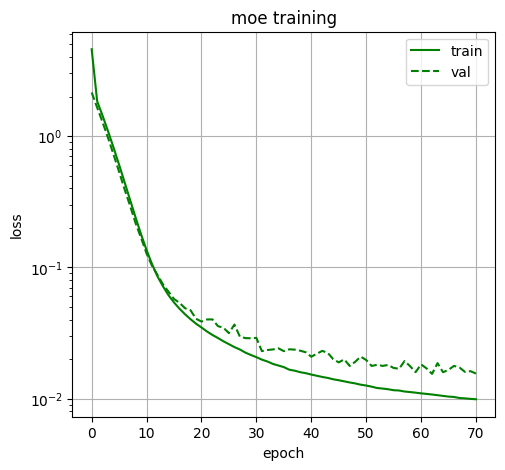

In [147]:
# training

import models.pointwise_moe_adpt
import importlib
importlib.reload(models.pointwise_moe_adpt)

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# loss
import models.decoder_losses
importlib.reload(models.decoder_losses)




# compile
decoder_pw_mod.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# callbacks
save_dir = "saved_models/vae_gru_moe"
os.makedirs(save_dir, exist_ok=True)
callbacks = [
  EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, min_delta=1e-5),
  ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=4, min_lr=1e-7),
  ModelCheckpoint(f"{save_dir}/decoder_final.keras", save_best_only=True, verbose=0)
]

print(f"moe pipeline: gru -> z_latents + y_prime_f -> moe -> y_hat")
print(f"input: z({Z_latents.shape[1]}) + yf({Y_prime_F.shape[1]}) = {X_train[0].shape[1]} dims")
print(f"training: {X_train[0].shape[0]} samples")

# fit
history = decoder_pw_mod.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=256, # set 256 25min for speed best results 32 , 2-3 hours
  epochs=100,
  callbacks=callbacks,
  verbose=1
)

decoder_pw_mod.save(f"{save_dir}/decoder_adpt.keras")
print(f"train: {history.history['loss'][-1]:.6f} | val: {history.history['val_loss'][-1]:.6f}")

# plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train", color='green')
plt.plot(history.history["val_loss"], label="val", color='green', linestyle='--')
plt.title("moe training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')



expert analysis:
  activations: [0.17691734 0.10836335 0.08058303 0.07845719 0.13340132 0.14183566
 0.28044211]
  entropy: 1.348
  active: 7/7


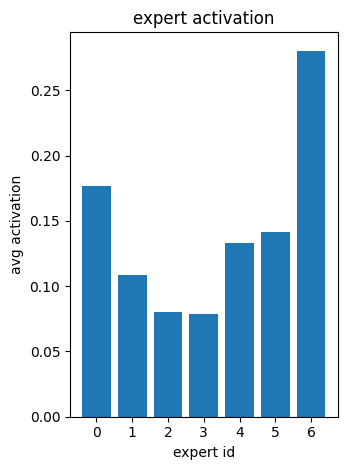

In [148]:
import models.pointwise_moe_adpt
import importlib
importlib.reload(models.pointwise_moe_adpt)
plt.subplot(1, 2, 2)
analysis = decoder_pw_mod.analyze_gating(X_val)
if analysis is not None:
   plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
   plt.title("expert activation")
   plt.xlabel("expert id")
   plt.ylabel("avg activation")
   plt.xticks(range(decoder_pw_mod.num_experts))
   
   print(f"\nexpert analysis:")
   print(f"  activations: {analysis['expert_activations']}")
   print(f"  entropy: {analysis['gate_entropy'].mean():.3f}")
   active = (np.array(analysis['expert_activations']) > 0.05).sum()
   print(f"  active: {active}/{decoder_pw_mod.num_experts}")

plt.tight_layout()
plt.show()

evaluating on test set
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Evaluation dimensions: N=189, M=11, K=10
moe 12-dim latent - test set RMSE_σ: 0.0122
RMSE by maturity (mean ± std): 0.0127 ± 0.0051
RMSE by strike    (mean ± std): 0.0135 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


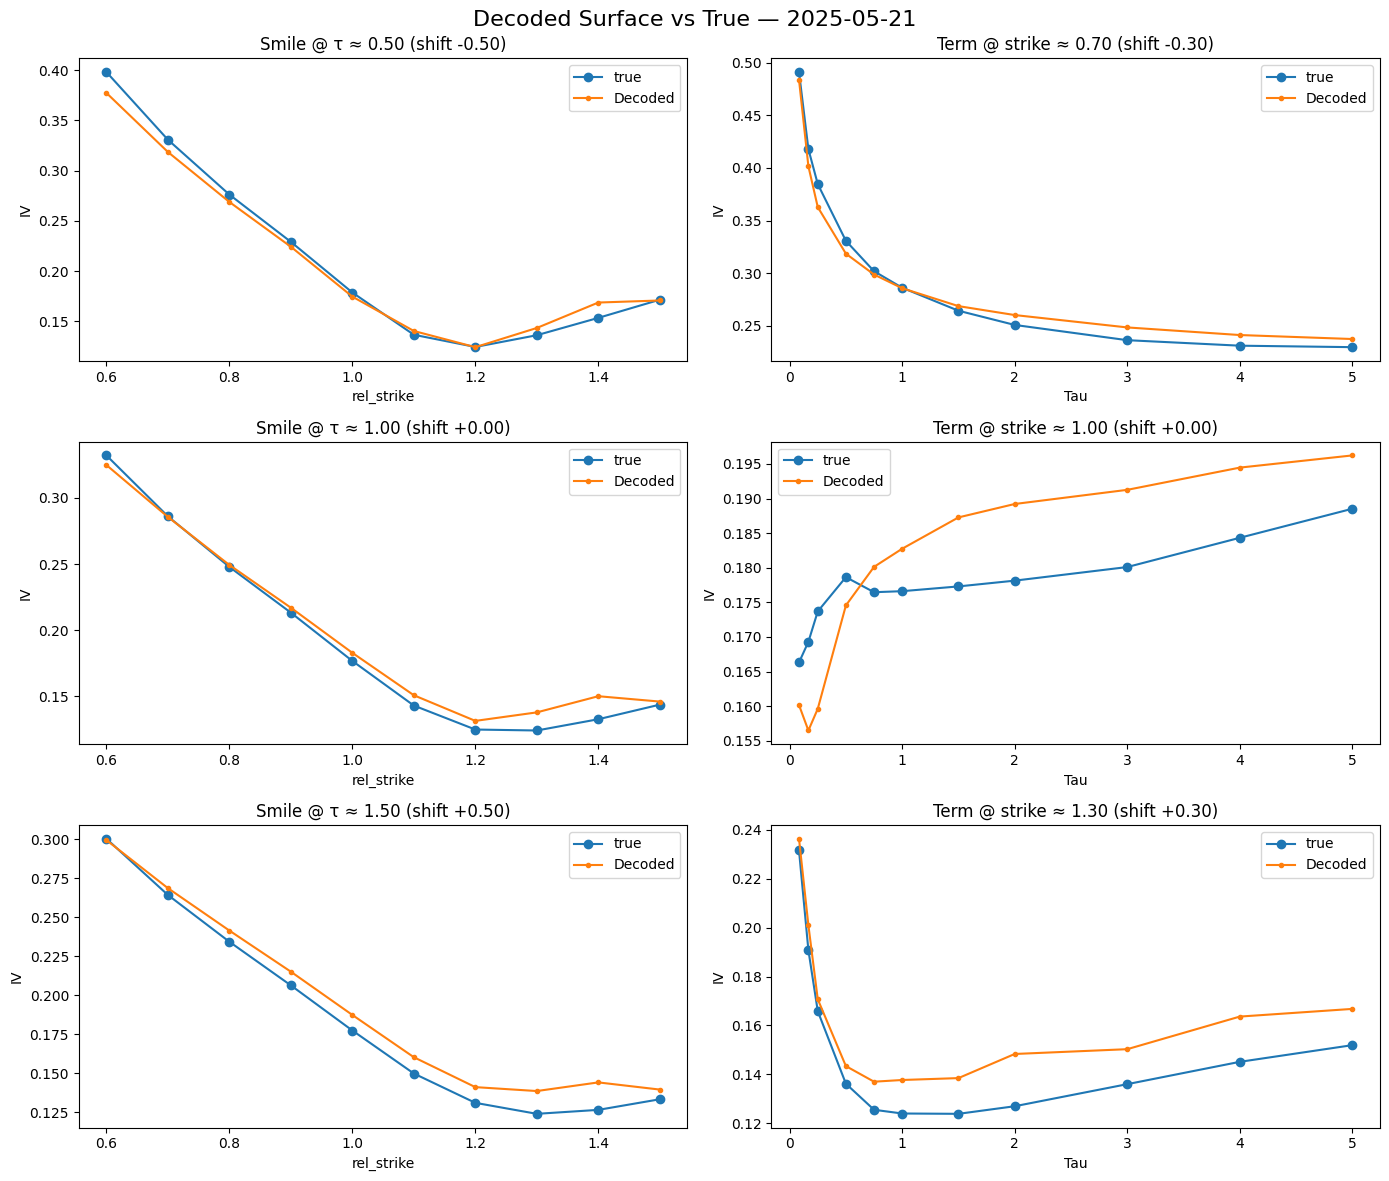

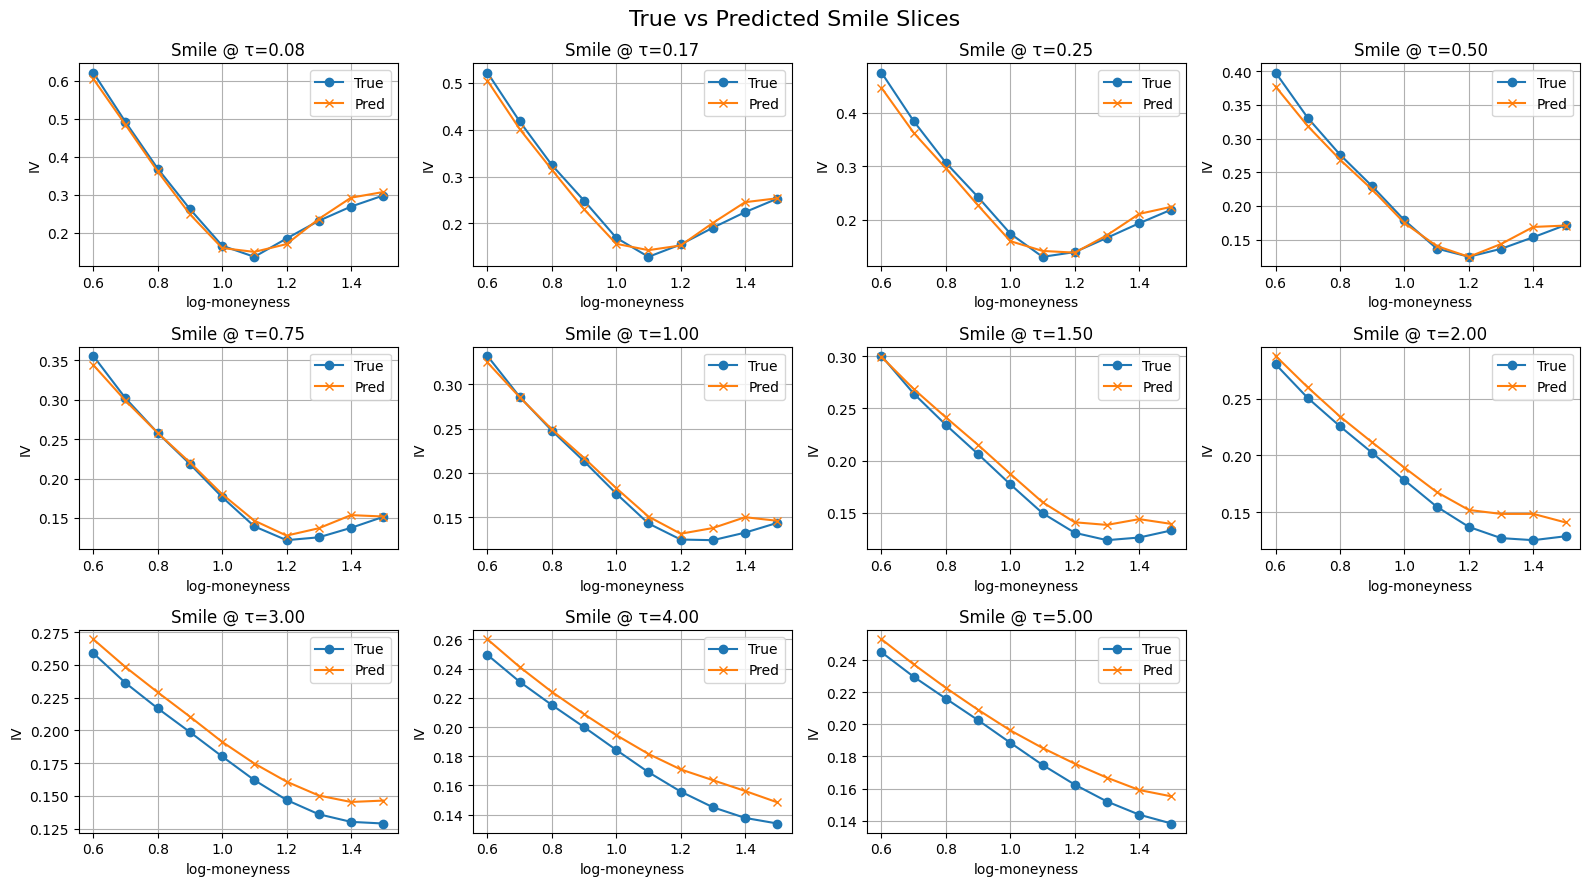

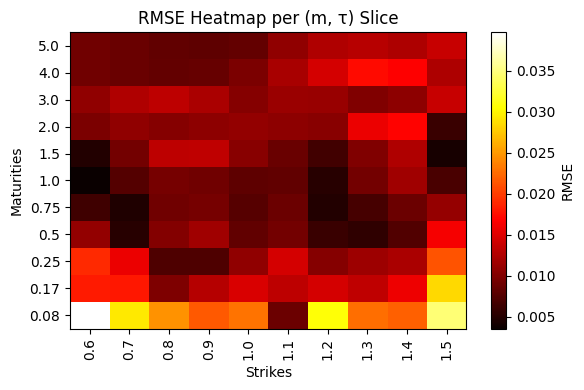

MoE Analysis
Experts: 7
Diversity: 1


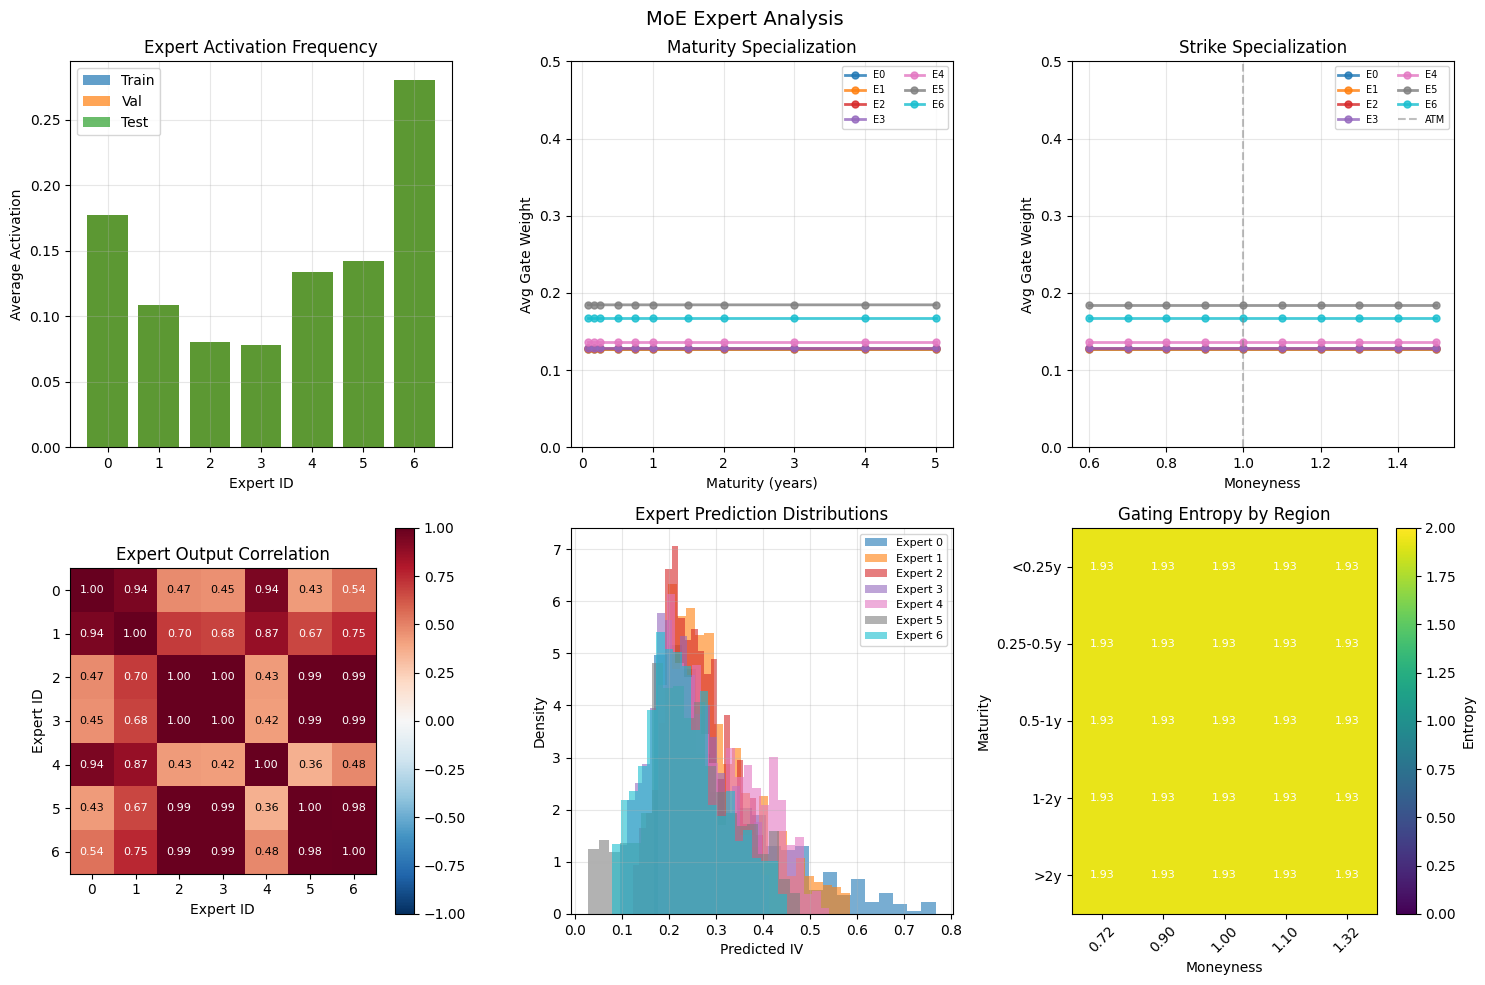


Summary:
Most active expert: 6
Least active expert: 3
Balance score: 0.935
Avg entropy: 1.348
Min correlation: 0.358
Max correlation: 1.000


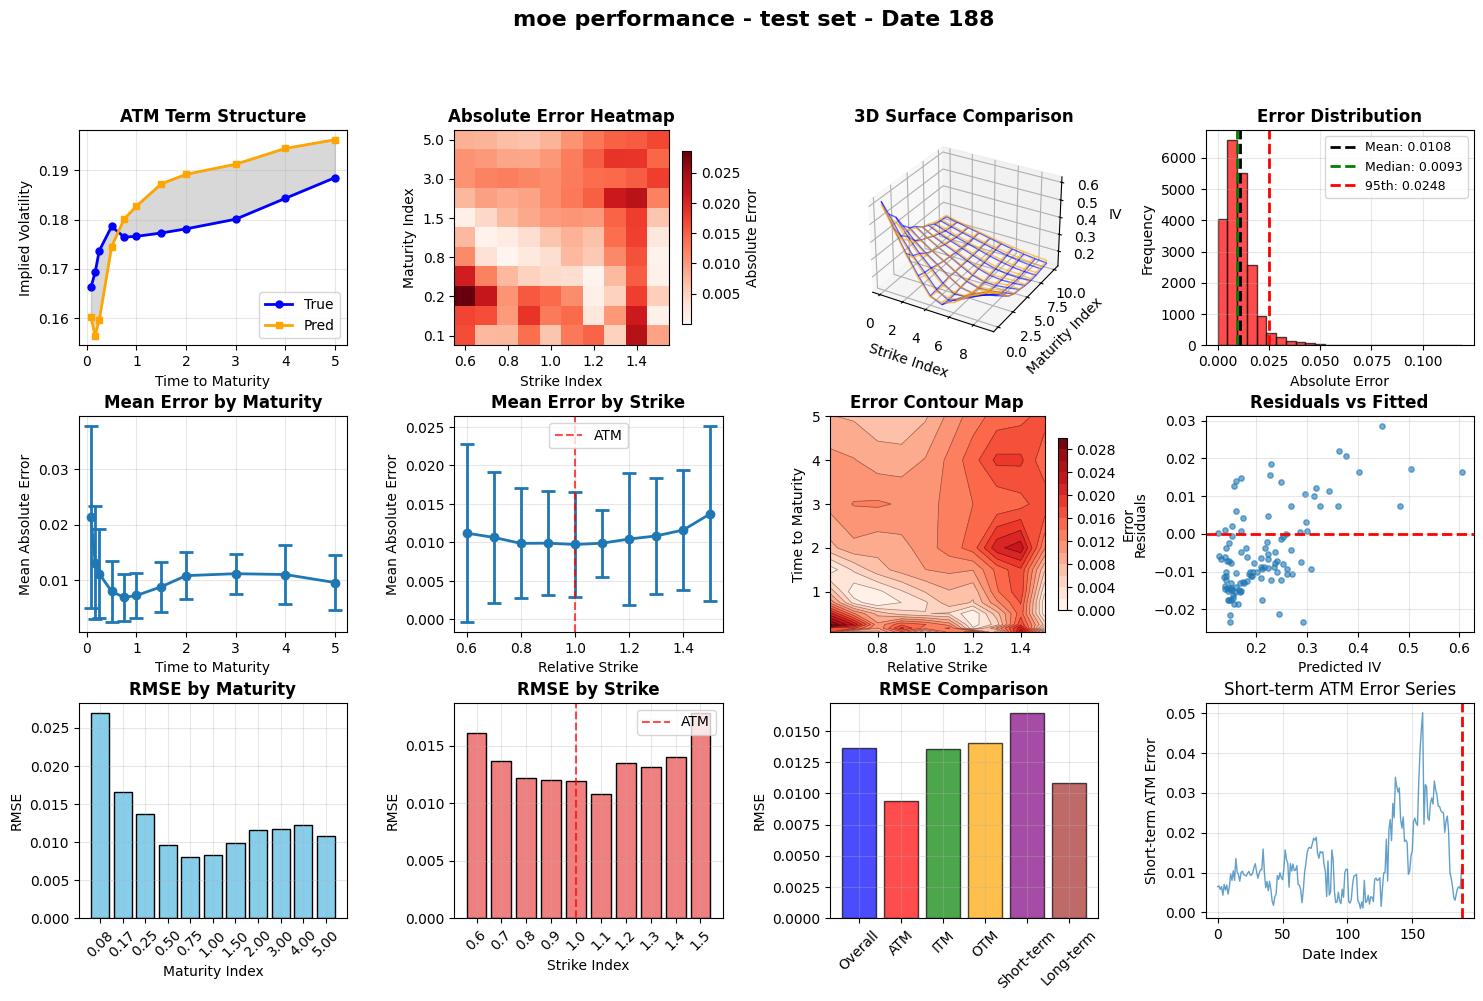

Overall Performance Category Performance  \
RMSE                           0.013661                  NaN   
MAE                            0.010800                  NaN   
Max Error                      0.119010                  NaN   
Mean Error                     0.010800                  NaN   
Median Error                   0.009348                  NaN   
95th Percentile                0.024808                  NaN   
ATM RMSE                            NaN             0.009424   
ITM RMSE                            NaN             0.013586   
OTM RMSE                            NaN             0.014043   
Short-term RMSE                     NaN             0.016434   
Long-term RMSE                      NaN             0.010819   
Short/Long Ratio                    NaN                1.519   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=0.75 (RMSE: 0.008063)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.026944)                       NaN  
Best Strike           K=1.1 (RMSE: 0.010826)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.017829)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.011904)                       NaN  
Overall Rank              ATM ranks #8 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.519)  
ATM Issues                               NaN   NO (ATM/Overall: 0.69x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.000457)  
High Error Variance                      NaN       YES (std: 0.008365)  
Model Quality                            NaN                      GOOD  
Recommendation                           NaN         Needs Improvement


rmse: 0.013661
vs gru-vae: 38.95% improvement


In [149]:
# eval

import models.pointwise_moe
import utils.eval
import utils.plot_error
import importlib
importlib.reload(models.pointwise_moe)
importlib.reload(utils.eval)
importlib.reload(utils.plot_error)

from utils.eval import evaluate_decoder_output_v2, analyze_moe_training_performance
from utils.plot_error import analyze_decoder_comprehensive

# config
EVAL_ON_TEST_ONLY = True

if EVAL_ON_TEST_ONLY:
  print("evaluating on test set")
  Z_eval = Z_latents_test
  Y_prime_F_eval = Y_prime_F_test
  Y_true_eval = Y_test.reshape(-1, M, K)
  eval_title = "test set"
else:
  print("evaluating on full dataset")
  Z_eval = Z_latents
  Y_prime_F_eval = Y_prime_F
  Y_true_eval = Y_true_aligned
  eval_title = "full dataset"

# grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# predictions
Z_eval_np = ops.convert_to_numpy(Z_eval) if hasattr(Z_eval, 'cpu') else Z_eval
Y_prime_F_eval_np = ops.convert_to_numpy(Y_prime_F_eval) if hasattr(Y_prime_F_eval, 'cpu') else Y_prime_F_eval
X_zf_eval = np.concatenate([Z_eval_np, Y_prime_F_eval_np], axis=1)

X_zf_expanded = np.repeat(X_zf_eval, M*K, axis=0)
X_m_expanded = np.tile(m_flat.flatten(), len(Z_eval))[:, None]
X_tau_expanded = np.tile(tau_flat.flatten(), len(Z_eval))[:, None]

y_hat_flat = decoder_pw_mod.predict([X_zf_expanded, X_m_expanded, X_tau_expanded])
Y_hat_moe = y_hat_flat.reshape(-1, M, K)

# evaluate
evaluate_decoder_output_v2(
  Y_pred=Y_hat_moe,
  Y_true=Y_true_eval,
  tensors=tensors,
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  taus=ops.convert_to_numpy(tensors["taus"]),
  target_date=TARGET_DATE,
  target_tau=TARGET_TAU,
  target_strike=TARGET_STRIKE,
  decoder=decoder_pw_mod,
  title=f"moe 12-dim latent - {eval_title}"
)

if EVAL_ON_TEST_ONLY:
  results = analyze_moe_training_performance(
      decoder_pw_mod, X_train, X_val, X_test, 
      y_train, y_val, y_test
  )

metrics = analyze_decoder_comprehensive(
  Y_true=Y_true_eval,
  Y_pred=Y_hat_moe,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title=f"moe performance - {eval_title}"
)

# comparison
rmse_moe = np.sqrt(np.mean((Y_true_eval.reshape(-1) - Y_hat_moe.reshape(-1))**2))
print(f"\nrmse: {rmse_moe:.6f}")

if 'rmse_gru_vae' in locals():
   improvement = ((rmse_gru_vae - rmse_moe) / rmse_gru_vae * 100)
   print(f"vs gru-vae: {improvement:.2f}% improvement")